In [1]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import ast

import json
import xmltodict

import stable_baselines3

from collections import defaultdict

import math

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
EVAL_FOLDER = '../evaluations'
META_FOLDER = "../meta"

In [3]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix, traffic):
    with open(f"{META_FOLDER}/{traffic}.json") as f:
        meta_data = json.load(f)
    def translate_action(action):
        # TODO: add fix in evaluate script
        if action.startswith("["):
            action = action.replace("  ", " ").replace("[ ", "[").replace(" ", ", ")
        action = ast.literal_eval(action)
        tf_ids = list(ast.literal_eval(df_single_episode.obs.to_list()[0]).keys())
        n_splits = len(action)
        if isinstance(action, list):
            if len(action) == 1:
                action_dict = {tf_ids[0]: action[0]}  # TODO: rename traffic signal in single traffic light scenario
            else:
                action_dict = {tf_ids[i]: a 
                              for i, a in enumerate(action)}
        
        green = []
        for tf_id, p in action_dict.items():
#             print(tf_id, p , meta_data[tf_id]["phases"])
            green_tf = f"{tf_id}:"
            green_tf += ", ".join(meta_data[tf_id]["phases"][str(p)]["lanes_green"])
            green.append(green_tf)
        return "; ".join(green)
    print("Loading", f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    df_single_episode["translated_action"]= df_single_episode['action'].apply(
        lambda x: translate_action(x)
    )
    n_splits = len(df_single_episode.translated_action.to_list()[0].split("; "))
    df_single_episode[[f"translated_action_tf_{i}"
                      for i in range(n_splits)]] = df_single_episode['translated_action'].str.split('; ', expand=True)
    
    
    df_multiple_episodes = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_100_episode.csv')
    df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    # df_multiple_episodes = None
    return df_single_episode, df_multiple_episodes

def compare_datasets(datasets):
    results = []
    for name, df in datasets:
        data = {
            'dataset': name,
#             'avg_cumulative_reward': np.mean(df.cumulative_reward.to_list()),
            # 'mean_waiting_time': np.mean(df.mean_waiting_time.to_list()),
            
            'avg_travel_time': np.mean(df.avg_travel_time.to_list()),
            'avg_time_loss': np.mean(df.avg_time_loss.to_list()),
            'avg_waiting_time': np.mean(df.avg_waiting_time.to_list()),

            'collisions': np.mean(df.collisions.to_list()),
            'emergency_braking': np.mean(df.emergency_braking.to_list()),
            'emergency_stops': np.mean(df.emergency_stops.to_list()),

#             'mean_speed': np.mean(df.mean_speed.to_list()),
            'mean_lane_density': np.mean(df.mean_lane_density.to_list()),
            'mean_queue': np.mean(df.mean_queue_length.to_list()),

        }
        results.append(data)
    return pd.DataFrame(results)

In [71]:
# A2C models experiment 1: High and low traffic scenarios
MODEL_HIGH = "a2c_custom-2way-single-intersection-high_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1"
MODEL_LOW = "a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1"

In [7]:
# A2C models experiment 2: Broken traffic light scenario
MODEL_HIGH = "a2c_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1" 
MODEL_LOW = "a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1" 

In [72]:
# TODO: fix naming
prefix = [MODEL_LOW, MODEL_HIGH]
base_traffic = "custom-2way-single-intersection"
traffic_scenario1 = f"{base_traffic}-low"
datasets1 = [
    (
        "a=" + "_".join(p.split("_")[:2]).replace(base_traffic, "") + f";t={traffic_scenario1}",
        load_data(p, traffic_scenario1)[1]
    ) for p in prefix
]
traffic_scenario2 = f"{base_traffic}-high"
datasets2 = [
    (
        "a=" +"_".join(p.split("_")[:2]).replace(base_traffic, "")+ f";t={traffic_scenario2}",
        load_data(p, traffic_scenario2)[1]
    ) for p in prefix
]

datasets = datasets1 + datasets2
df_compare = compare_datasets(datasets)
df_compare

Loading ../evaluations/a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-low_1_episode.csv
Loading ../evaluations/a2c_custom-2way-single-intersection-high_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-low_1_episode.csv
Loading ../evaluations/a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-high_1_episode.csv
Loading ../evaluations/a2c_custom-2way-single-intersection-high_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-high_1_episode.csv


,dataset,avg_travel_time,avg_time_loss,avg_waiting_time,collisions,emergency_braking,emergency_stops,mean_lane_density,mean_queue
0,a=a2c_-low;t=custom-2way-single-intersection-low,32.760852,11.1255,5.7555,0.0,0.0,0.0,0.125548,0.68950
1,a=a2c_-high;t=custom-2way-single-intersection-low,36.901405,15.2674,9.8910,0.0,0.0,0.0,0.148534,1.15285
2,a=a2c_-low;t=custom-2way-single-intersection-high,44.614207,22.9495,12.2168,0.0,0.0,0.0,0.481646,3.44905
3,a=a2c_-high;t=custom-2way-single-intersection-...,40.292746,18.6133,11.2856,0.0,0.0,0.0,0.416352,3.19050


In [8]:
traffic_scenario = '3x3grid-3lanes2'
prefix = [MODEL_LOW, MODEL_HIGH, f"{MODEL_LOW}_broken", f"{MODEL_HIGH}_broken"]
datasets = [(
    p,
        load_data(p, traffic_scenario)[1]
    ) for p in prefix]
df_compare = compare_datasets(datasets)
df_compare

Loading ../evaluations/a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1_3x3grid-3lanes2_1_episode.csv
Loading ../evaluations/a2c_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1_3x3grid-3lanes2_1_episode.csv
Loading ../evaluations/a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1_broken_3x3grid-3lanes2_1_episode.csv
Loading ../evaluations/a2c_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1_broken_3x3grid-3lanes2_1_episode.csv


,dataset,avg_travel_time,avg_time_loss,avg_waiting_time,collisions,emergency_braking,emergency_stops,mean_lane_density,mean_queue
0,a2c_broken_3x3grid-3lanes2_250000_stepsintelli...,320.502787,259.2661,235.5747,0.0,0.01,0.0,3.111864,45.897931
1,a2c_3x3grid-3lanes2_250000_stepsintelli_light_...,269.911105,208.6257,185.6504,0.0,0.00,0.0,2.553266,36.142556
2,a2c_broken_3x3grid-3lanes2_250000_stepsintelli...,262.546999,206.6691,186.1198,0.0,0.00,0.0,7.789991,131.276403
3,a2c_3x3grid-3lanes2_250000_stepsintelli_light_...,277.087041,221.2449,200.6166,0.0,0.00,0.0,7.932389,133.787903


In [73]:
df_compare.to_csv("./compare.csv", index=False)

Loading ../evaluations/a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-high_1_episode.csv
Loading ../evaluations/a2c_custom-2way-single-intersection-high_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-high_1_episode.csv
Results custom-2way-single-intersection-high translated_action_tf_0


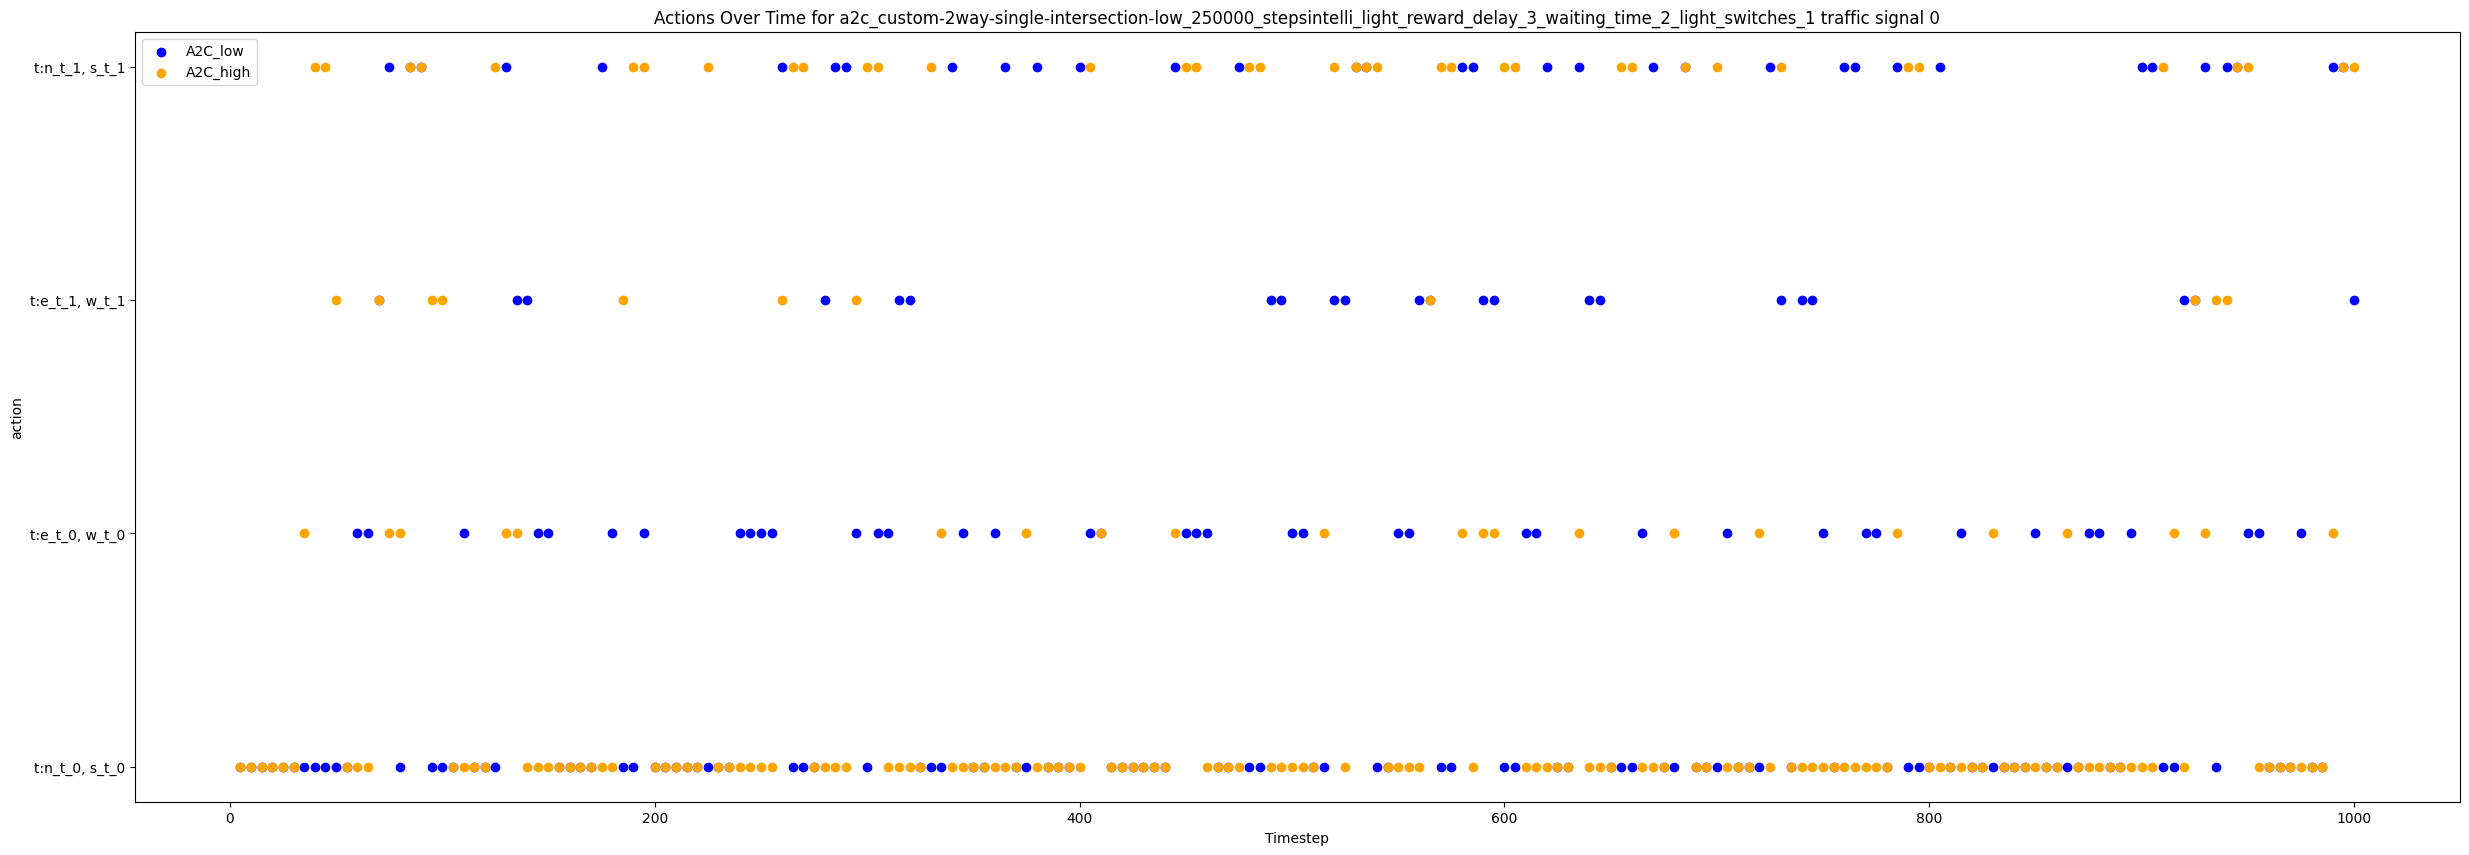

Action Distribution for a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1 traffic signal 0


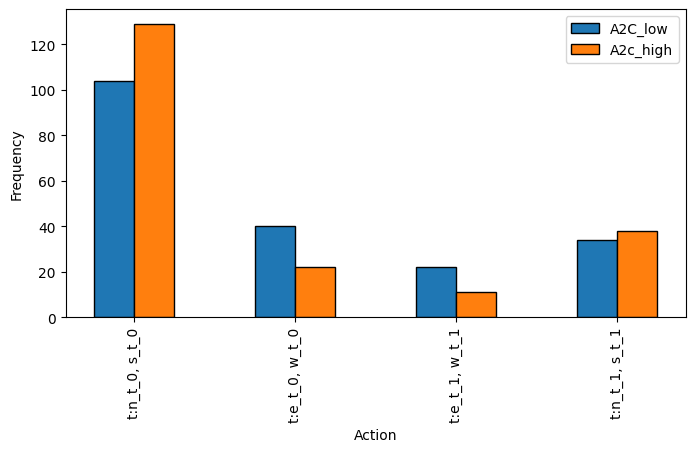

In [76]:
base_traffic = "custom-2way-single-intersection"
traffic = f"{base_traffic}-high"
df_single_episode_low, _ = load_data(MODEL_LOW, traffic)
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

n_splits = len(df_single_episode_high.translated_action.to_list()[0].split("; "))
for i in range(n_splits):
    column = f"translated_action_tf_{i}"
    print("Results", traffic, column)
    
    grouped = pd.DataFrame({f'{column}_model_low': df_single_episode_low[column],
                            f'{column}_model_high': df_single_episode_high[column]}) 
    
    plt.figure(figsize=(30, 10))
    plt.scatter(grouped.index, grouped[f"{column}_model_low"], color="blue", label="A2C_low")
    plt.scatter(grouped.index, grouped[f"{column}_model_high"], color="orange", label="A2C_high")

    plt.xlabel("Timestep")
    plt.ylabel("action")
    plt.title(f"Actions Over Time for {MODEL_LOW} traffic signal {i}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,4))
    categories = set(grouped[f'{column}_model_low'].unique() + grouped[f'{column}_model_high'].unique())

    plt.hist(grouped[[f'{column}_model_low', f'{column}_model_high']], label=["A2C_low", "A2c_high"],
             rwidth=0.5,
            bins=np.arange(len(categories)+1)-0.5, edgecolor='black')
    plt.xlabel("Action")
    plt.ylabel("Frequency")
    print(f"Action Distribution for {MODEL_LOW} traffic signal {i}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
    

Loading ../evaluations/a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-low_1_episode.csv
Loading ../evaluations/a2c_custom-2way-single-intersection-high_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1_custom-2way-single-intersection-low_1_episode.csv
Results custom-2way-single-intersection-low translated_action_tf_0


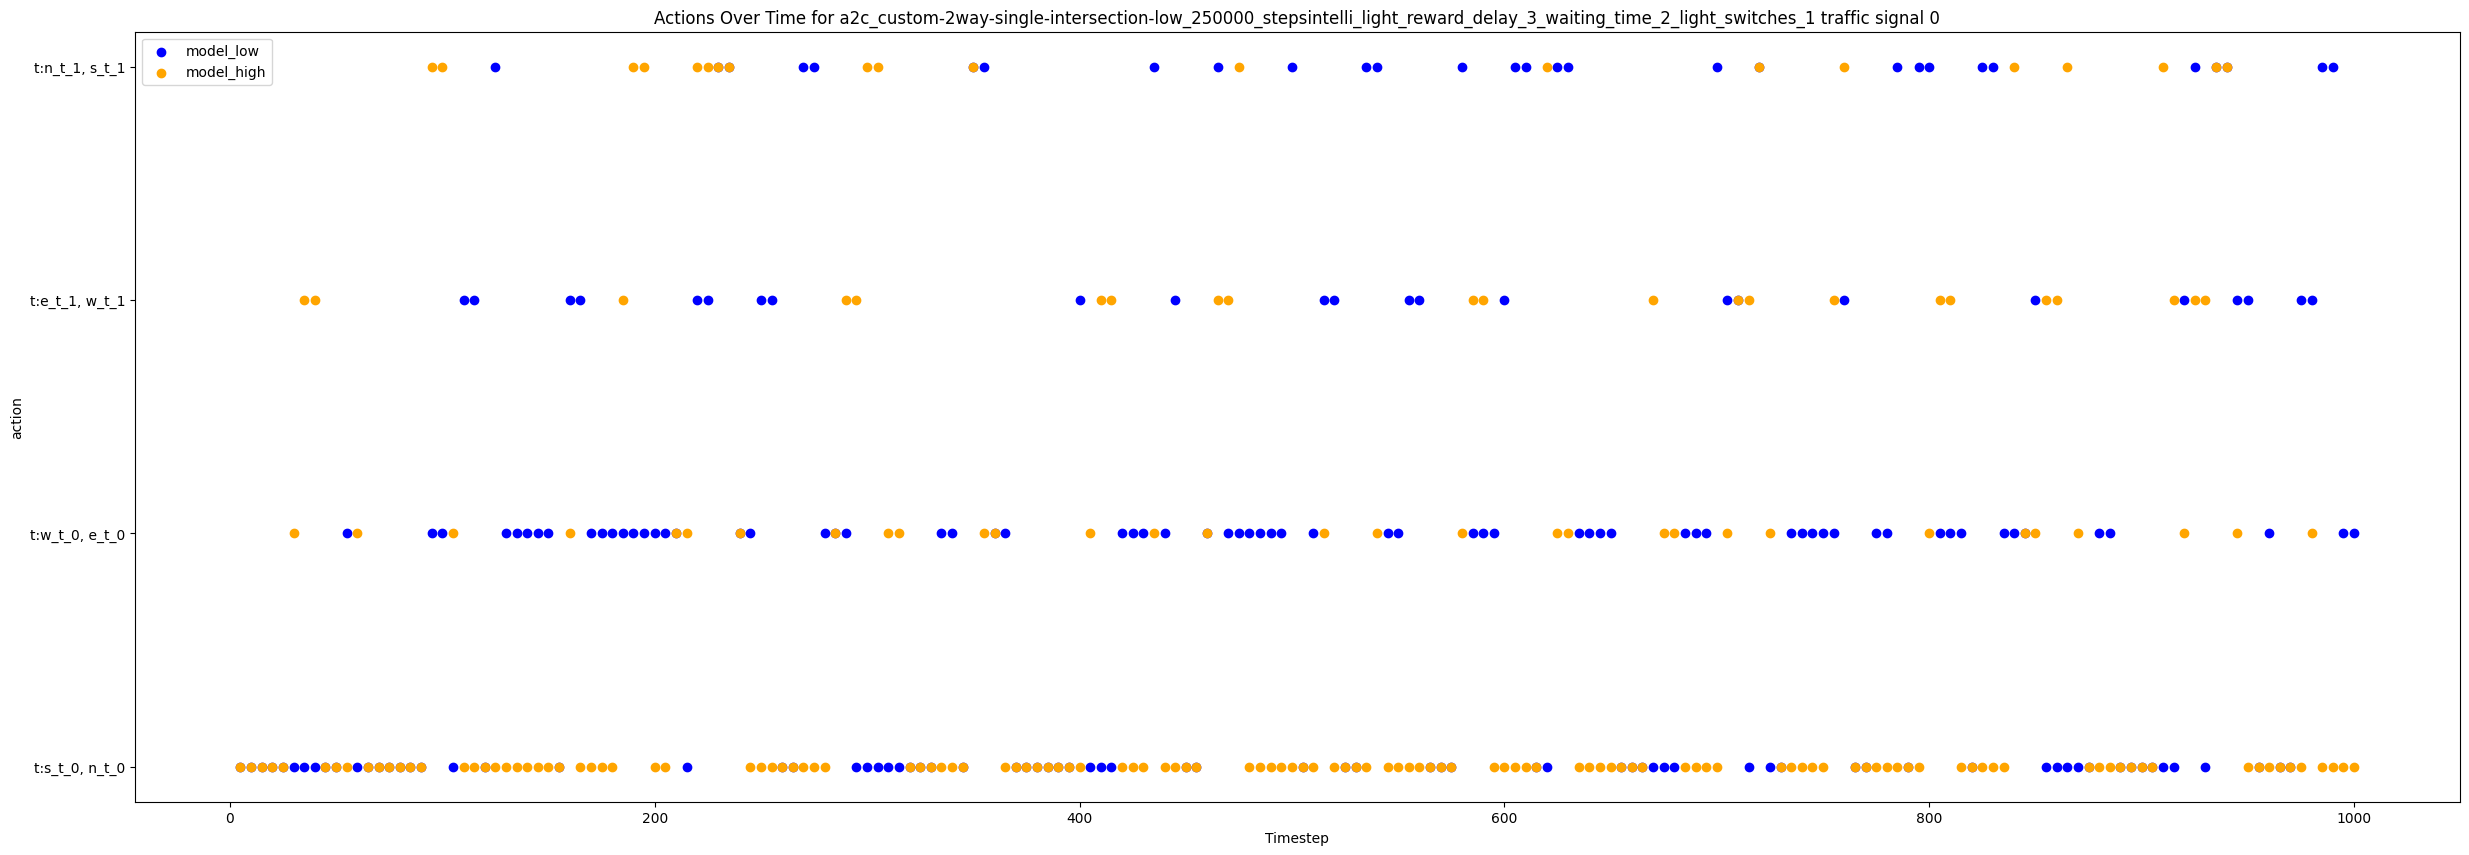

Action Distribution for a2c_custom-2way-single-intersection-low_250000_stepsintelli_light_reward_delay_3_waiting_time_2_light_switches_1 traffic signal 0


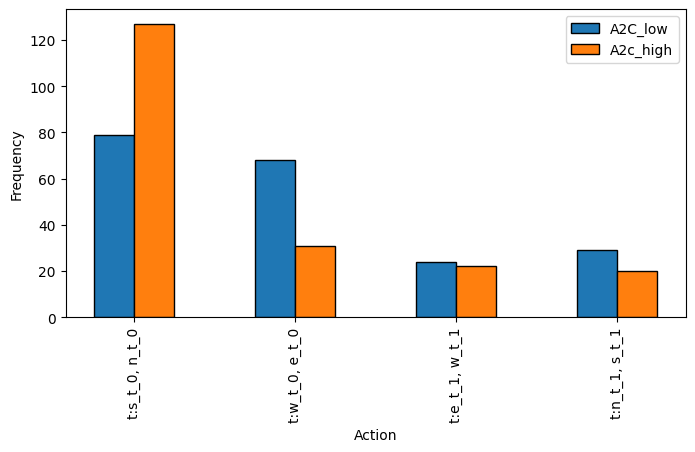

In [77]:
base_traffic = "custom-2way-single-intersection"
traffic = f"{base_traffic}-low"
df_single_episode_low, _ = load_data(MODEL_LOW, traffic)
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

n_splits = len(df_single_episode_high.translated_action.to_list()[0].split("; "))
for i in range(n_splits):
    column = f"translated_action_tf_{i}"
    print("Results", traffic, column)
    
    grouped = pd.DataFrame({f'{column}_model_low': df_single_episode_low[column],
                            f'{column}_model_high': df_single_episode_high[column]}) 
    
    plt.figure(figsize=(30, 10))
    plt.scatter(grouped.index, grouped[f"{column}_model_low"], color="blue", label="model_low")
    plt.scatter(grouped.index, grouped[f"{column}_model_high"], color="orange", label="model_high")

    plt.xlabel("Timestep")
    plt.ylabel("action")
    plt.title(f"Actions Over Time for {MODEL_LOW} traffic signal {i}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,4))
    categories = set(grouped[f'{column}_model_low'].unique() + grouped[f'{column}_model_high'].unique())

    plt.hist(grouped[[f'{column}_model_low', f'{column}_model_high']], label=["A2C_low", "A2c_high"],
             rwidth=0.5,
            bins=np.arange(len(categories)+1)-0.5, edgecolor='black')
    plt.xlabel("Action")
    plt.ylabel("Frequency")
    print(f"Action Distribution for {MODEL_LOW} traffic signal {i}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
    

Results 3x3grid-3lanes2 translated_action_tf_0
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 0


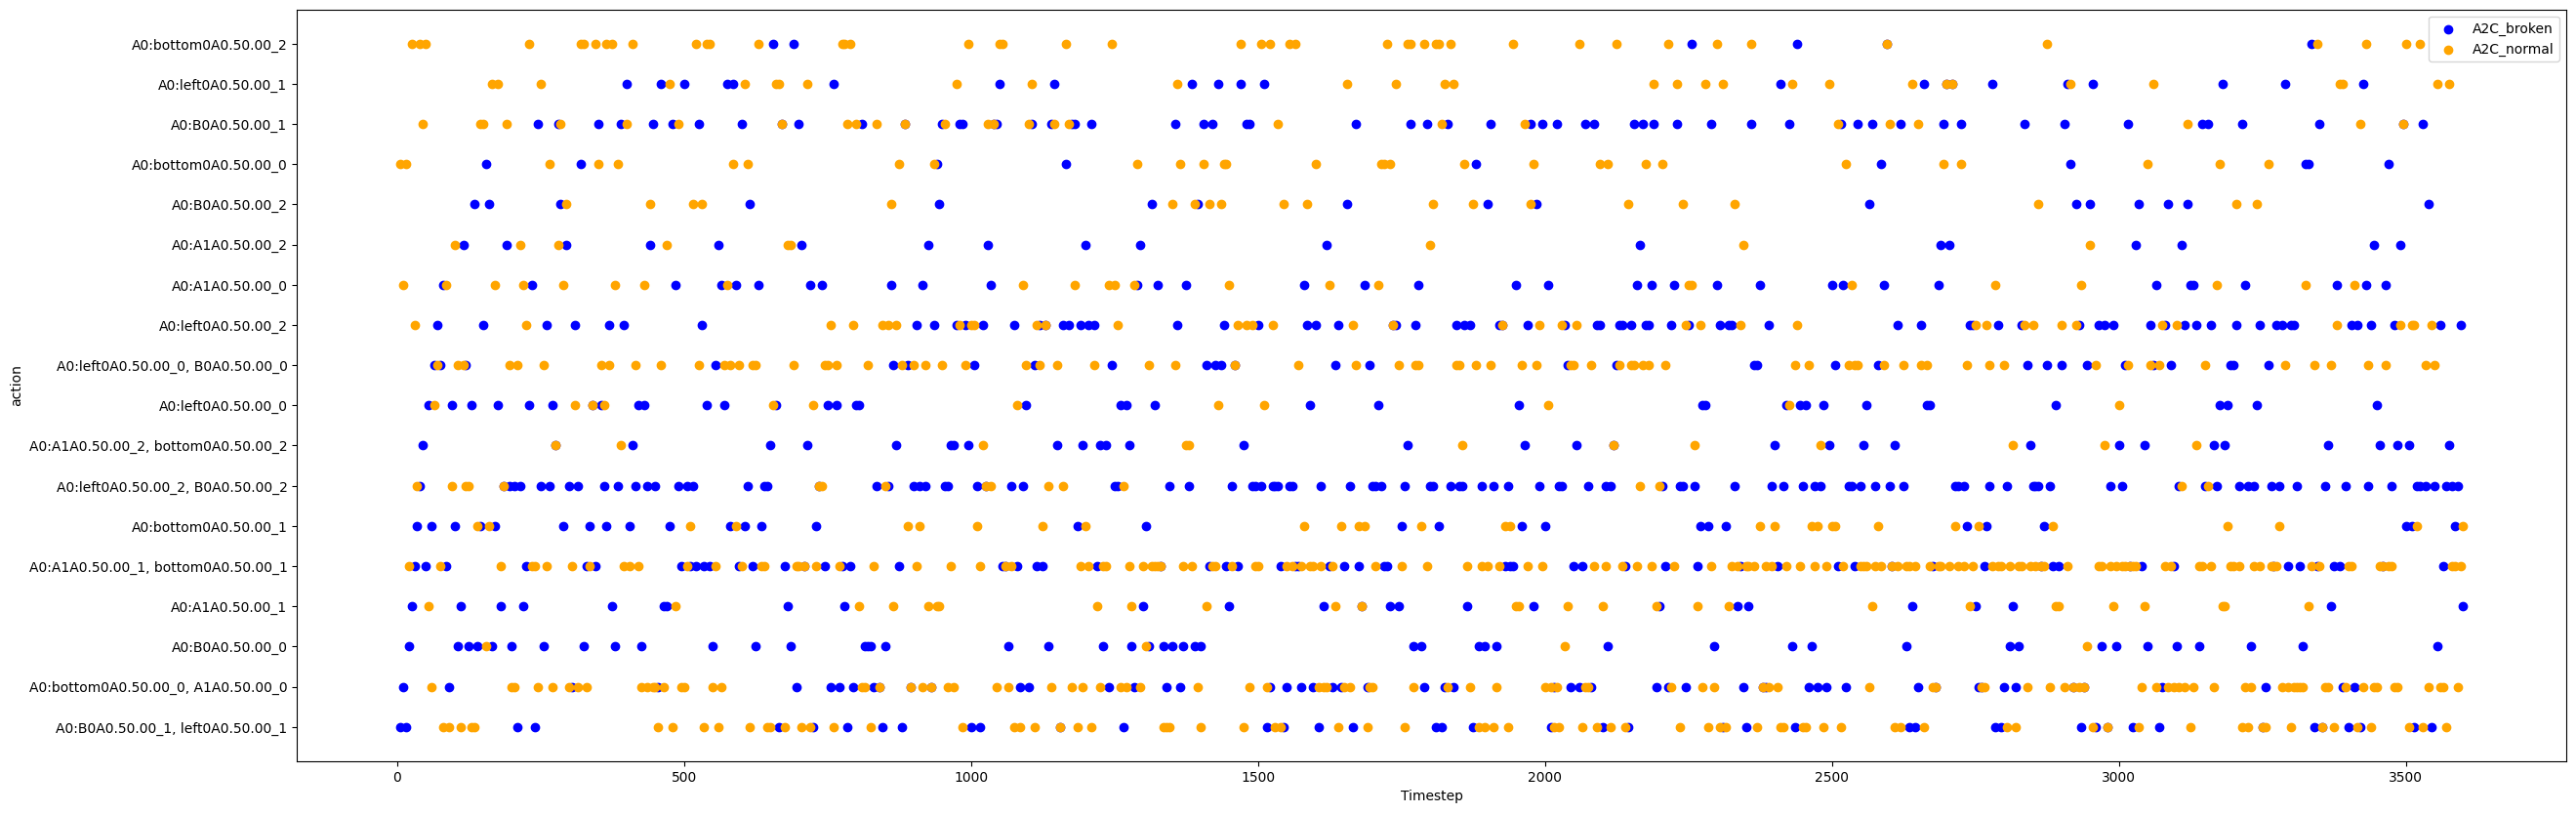

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 0


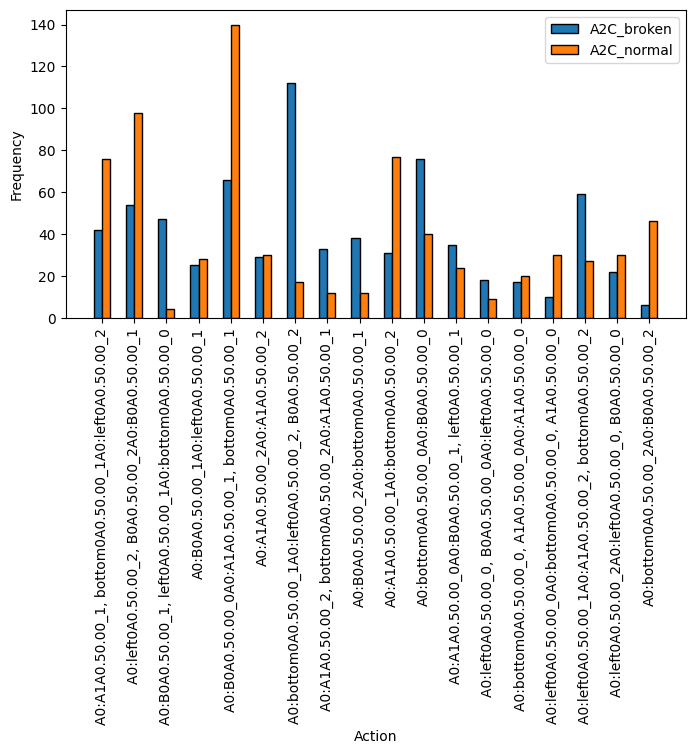

B1 actions for model low 0
B1 actions for model high 0
Results 3x3grid-3lanes2 translated_action_tf_1
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 1


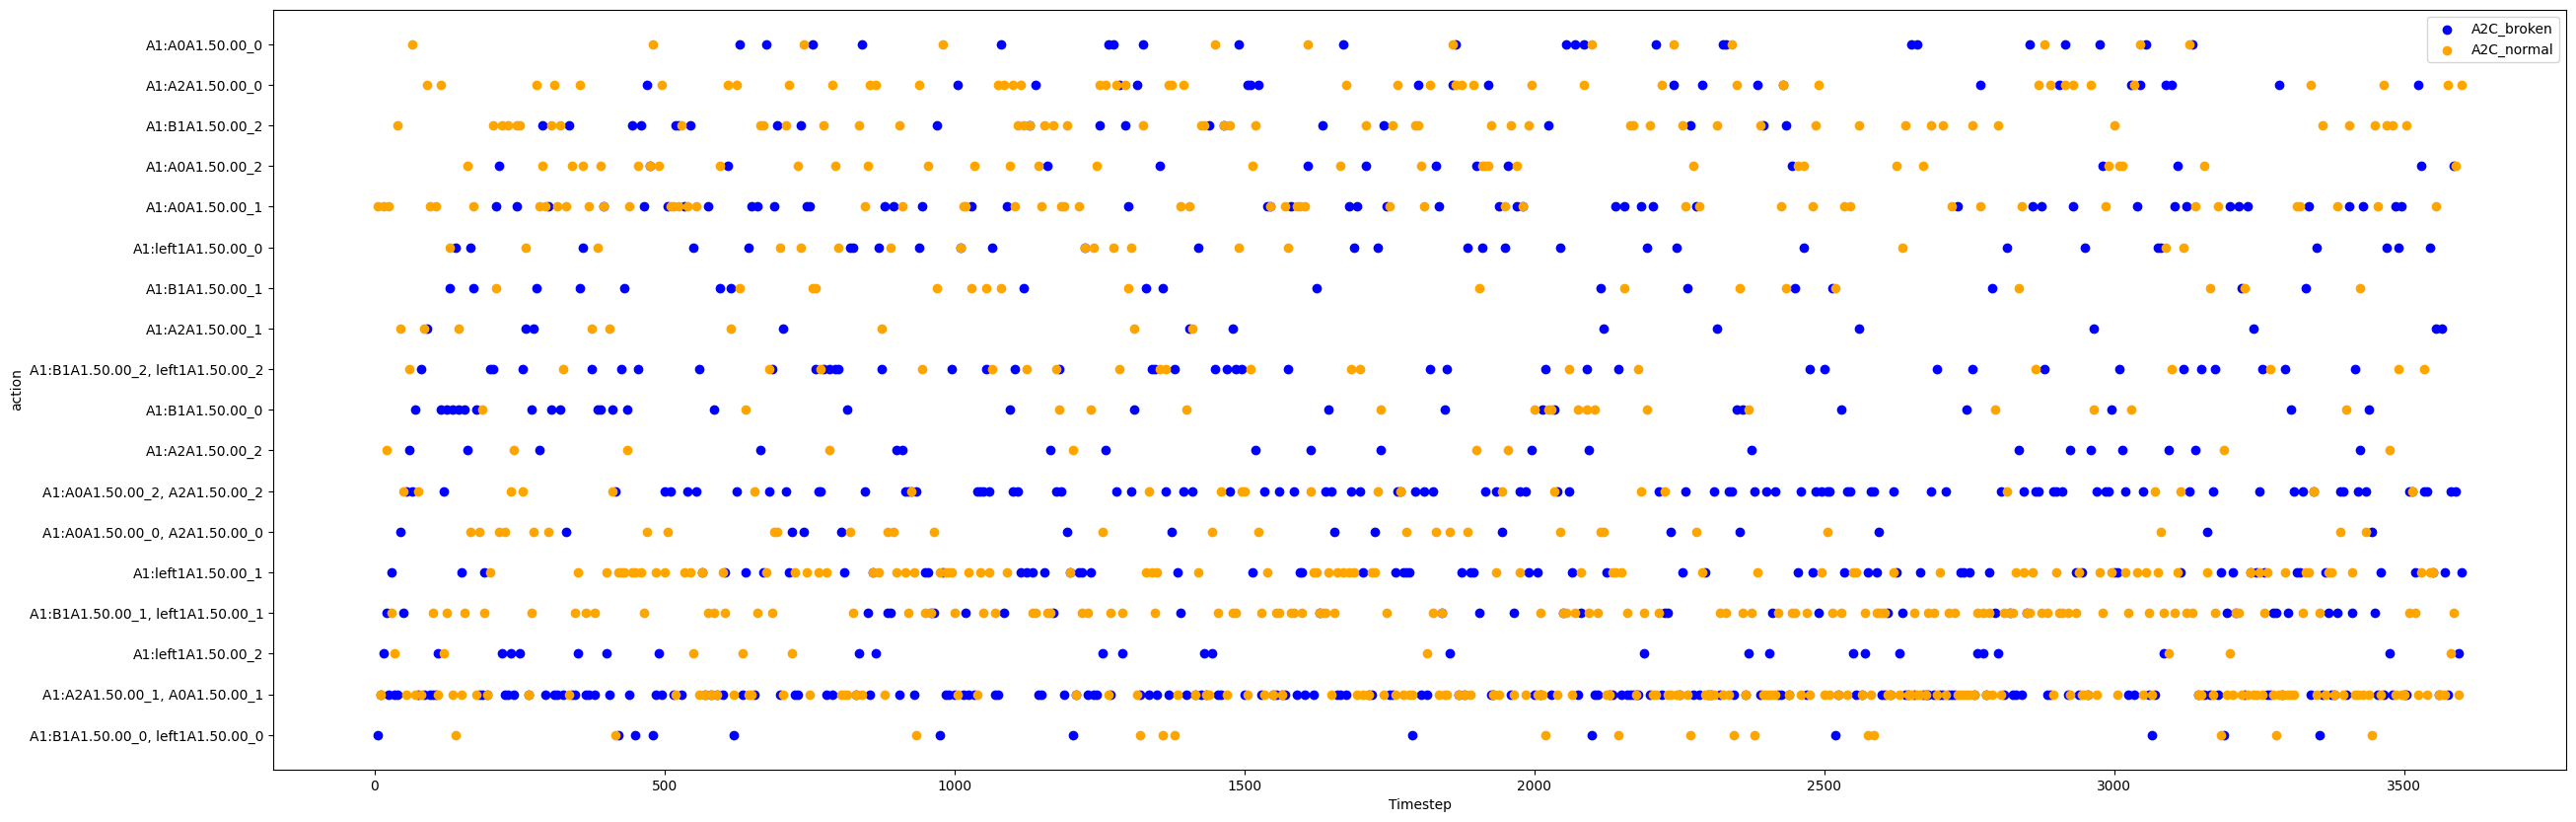

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 1


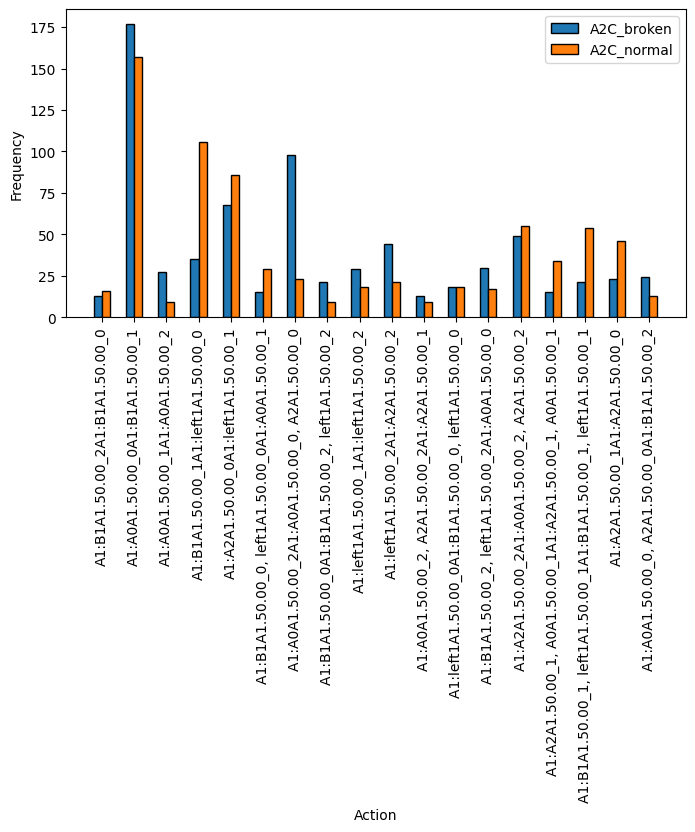

B1 actions for model low 160
B1 actions for model high 233
Results 3x3grid-3lanes2 translated_action_tf_2
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 2


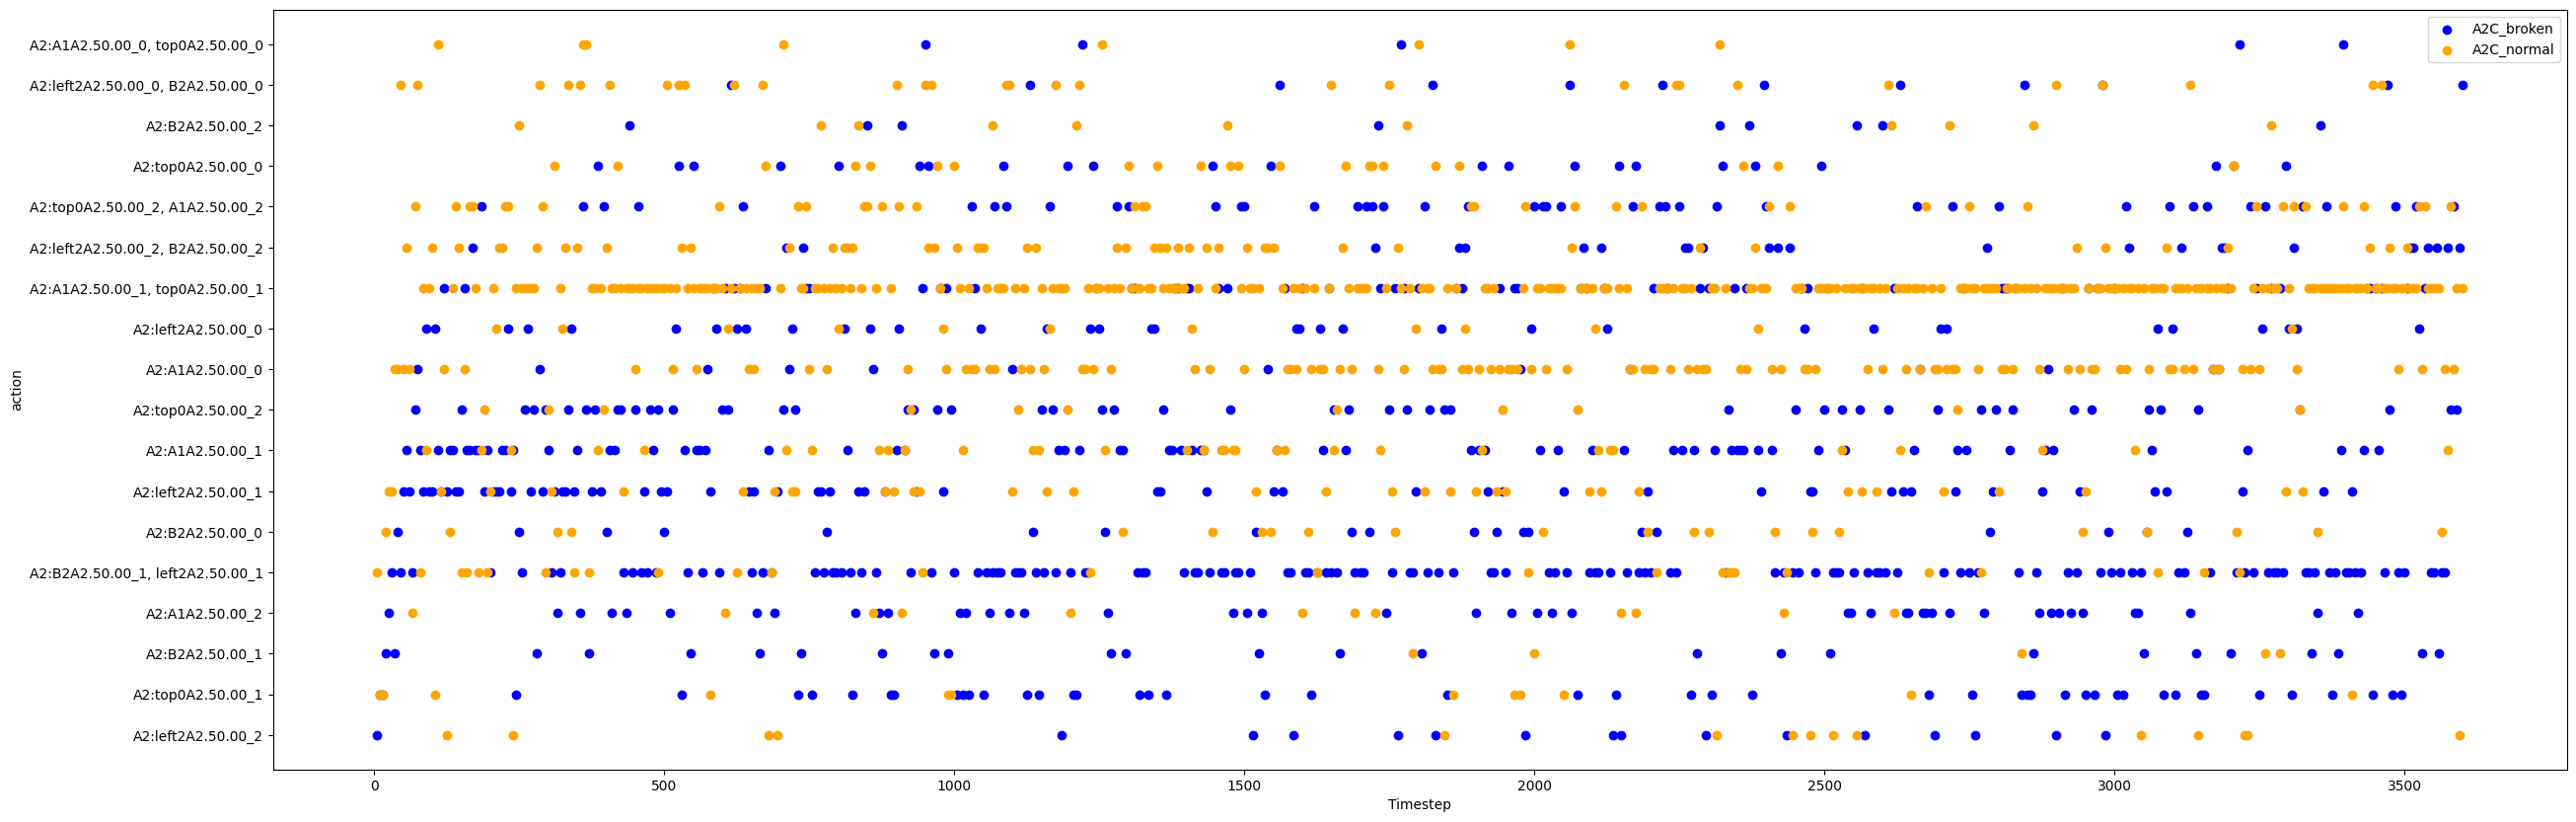

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 2


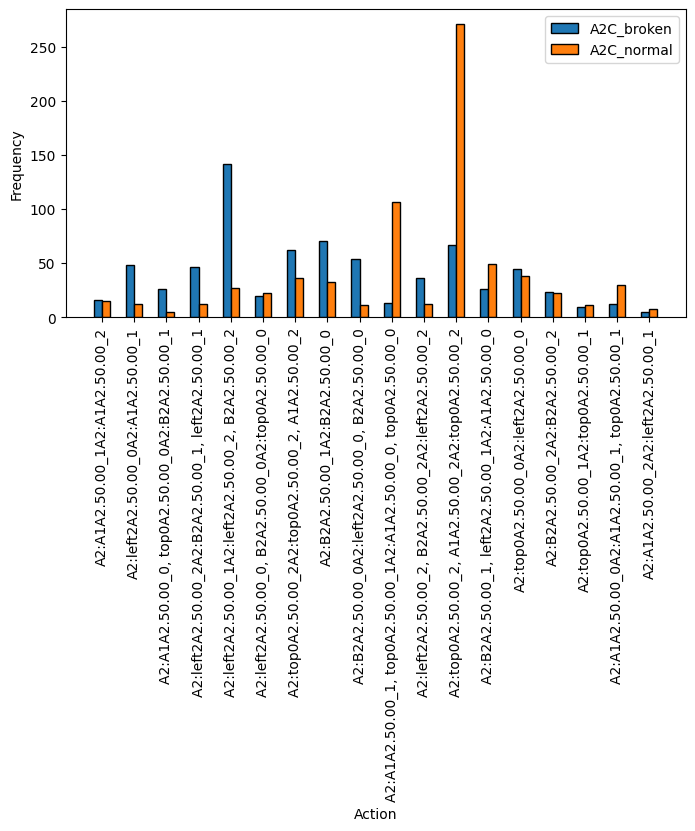

B1 actions for model low 0
B1 actions for model high 0
Results 3x3grid-3lanes2 translated_action_tf_3
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 3


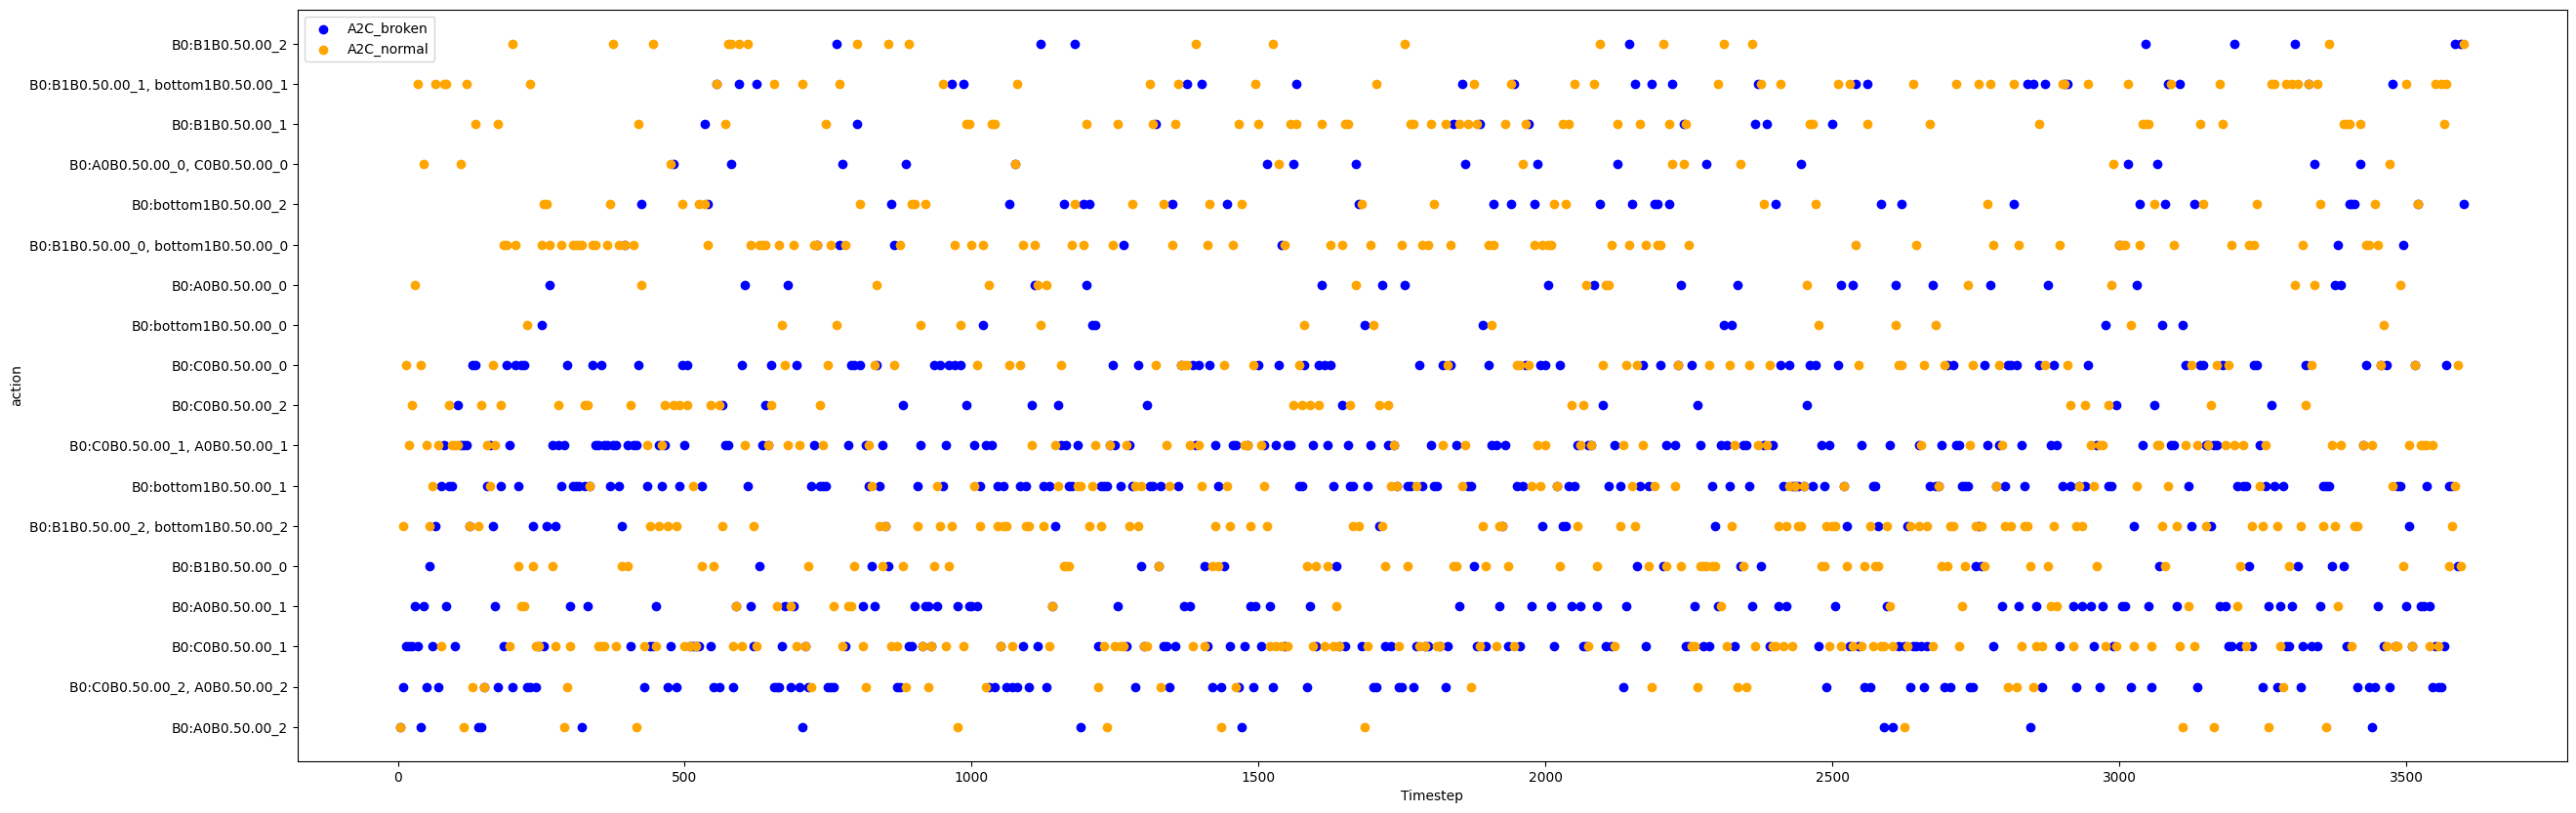

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 3


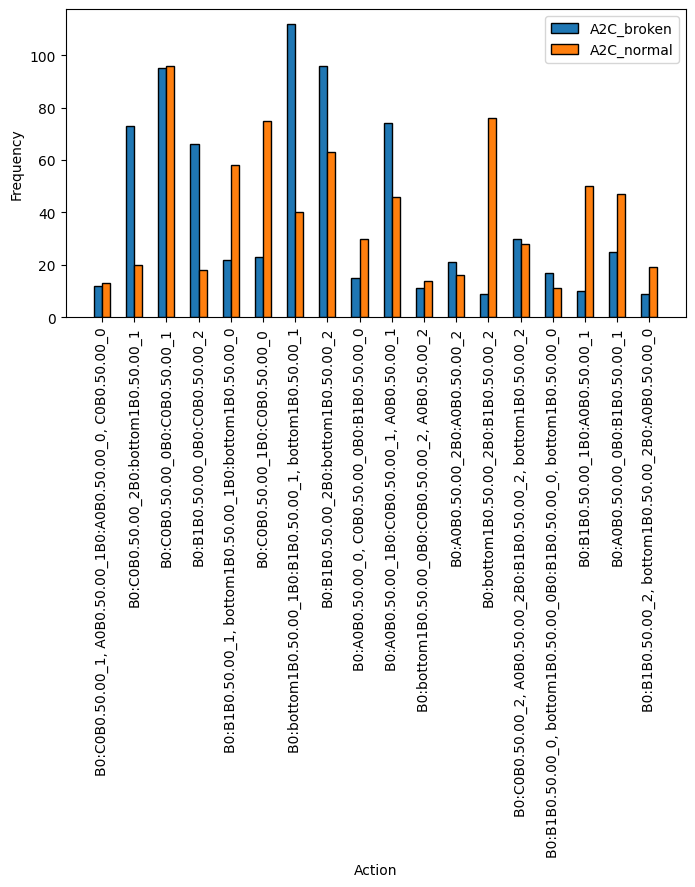

B1 actions for model low 98
B1 actions for model high 325
Results 3x3grid-3lanes2 translated_action_tf_4
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 4


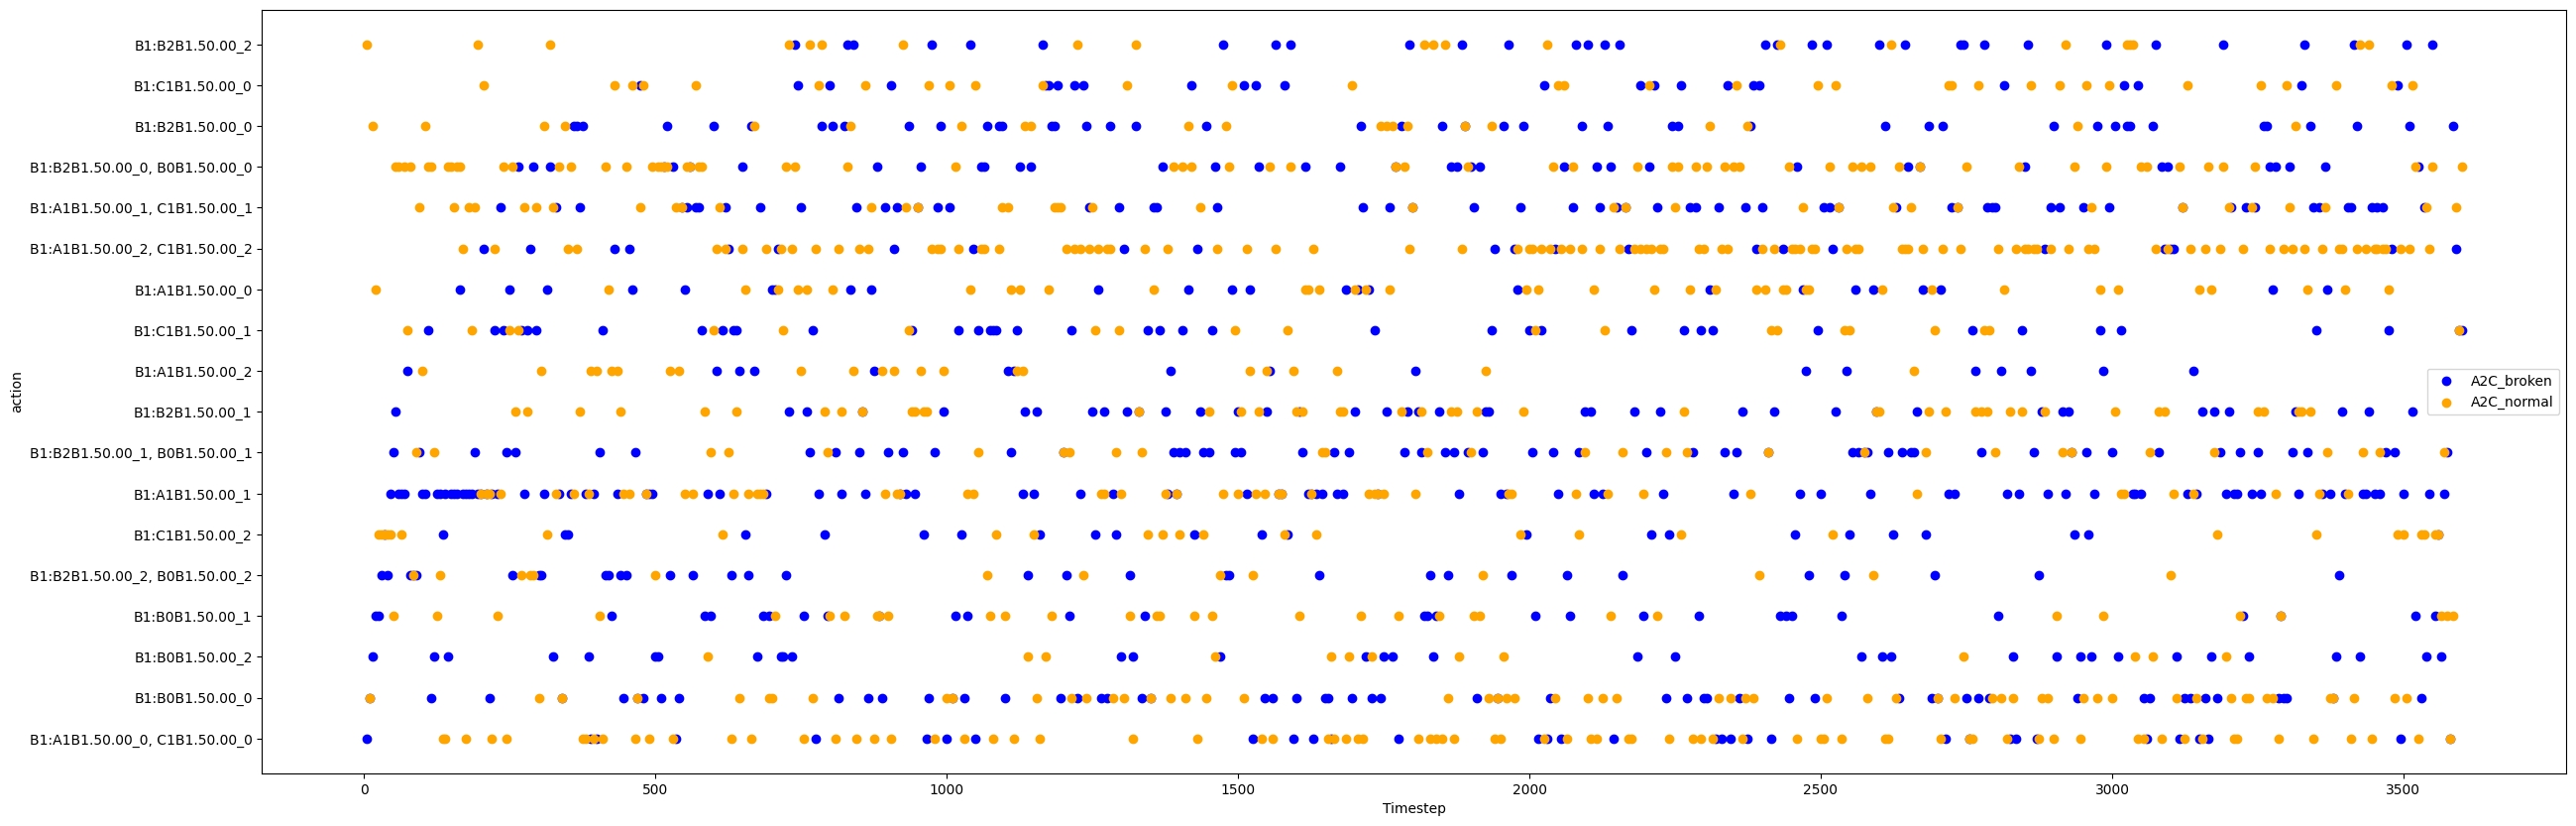

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 4


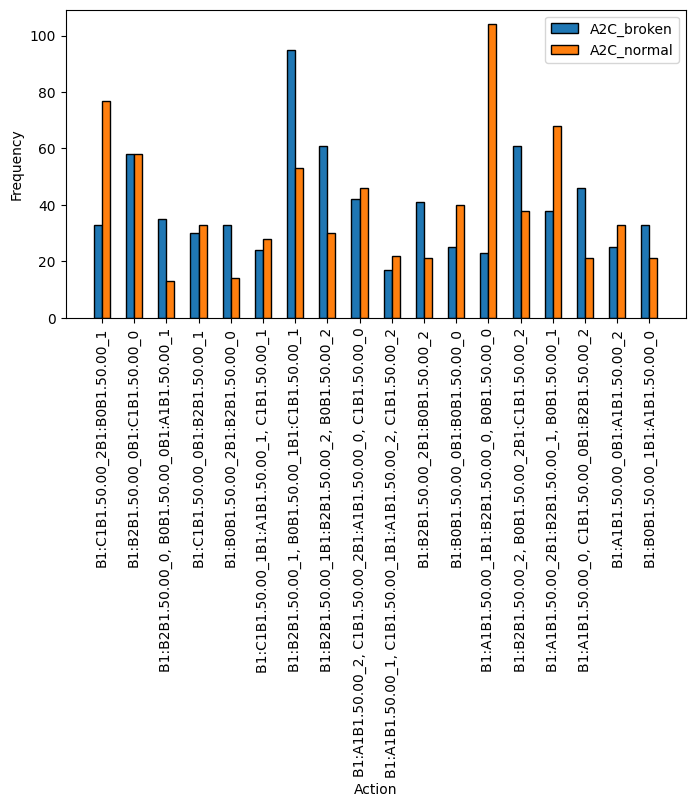

B1 actions for model low 720
B1 actions for model high 720
Results 3x3grid-3lanes2 translated_action_tf_5
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 5


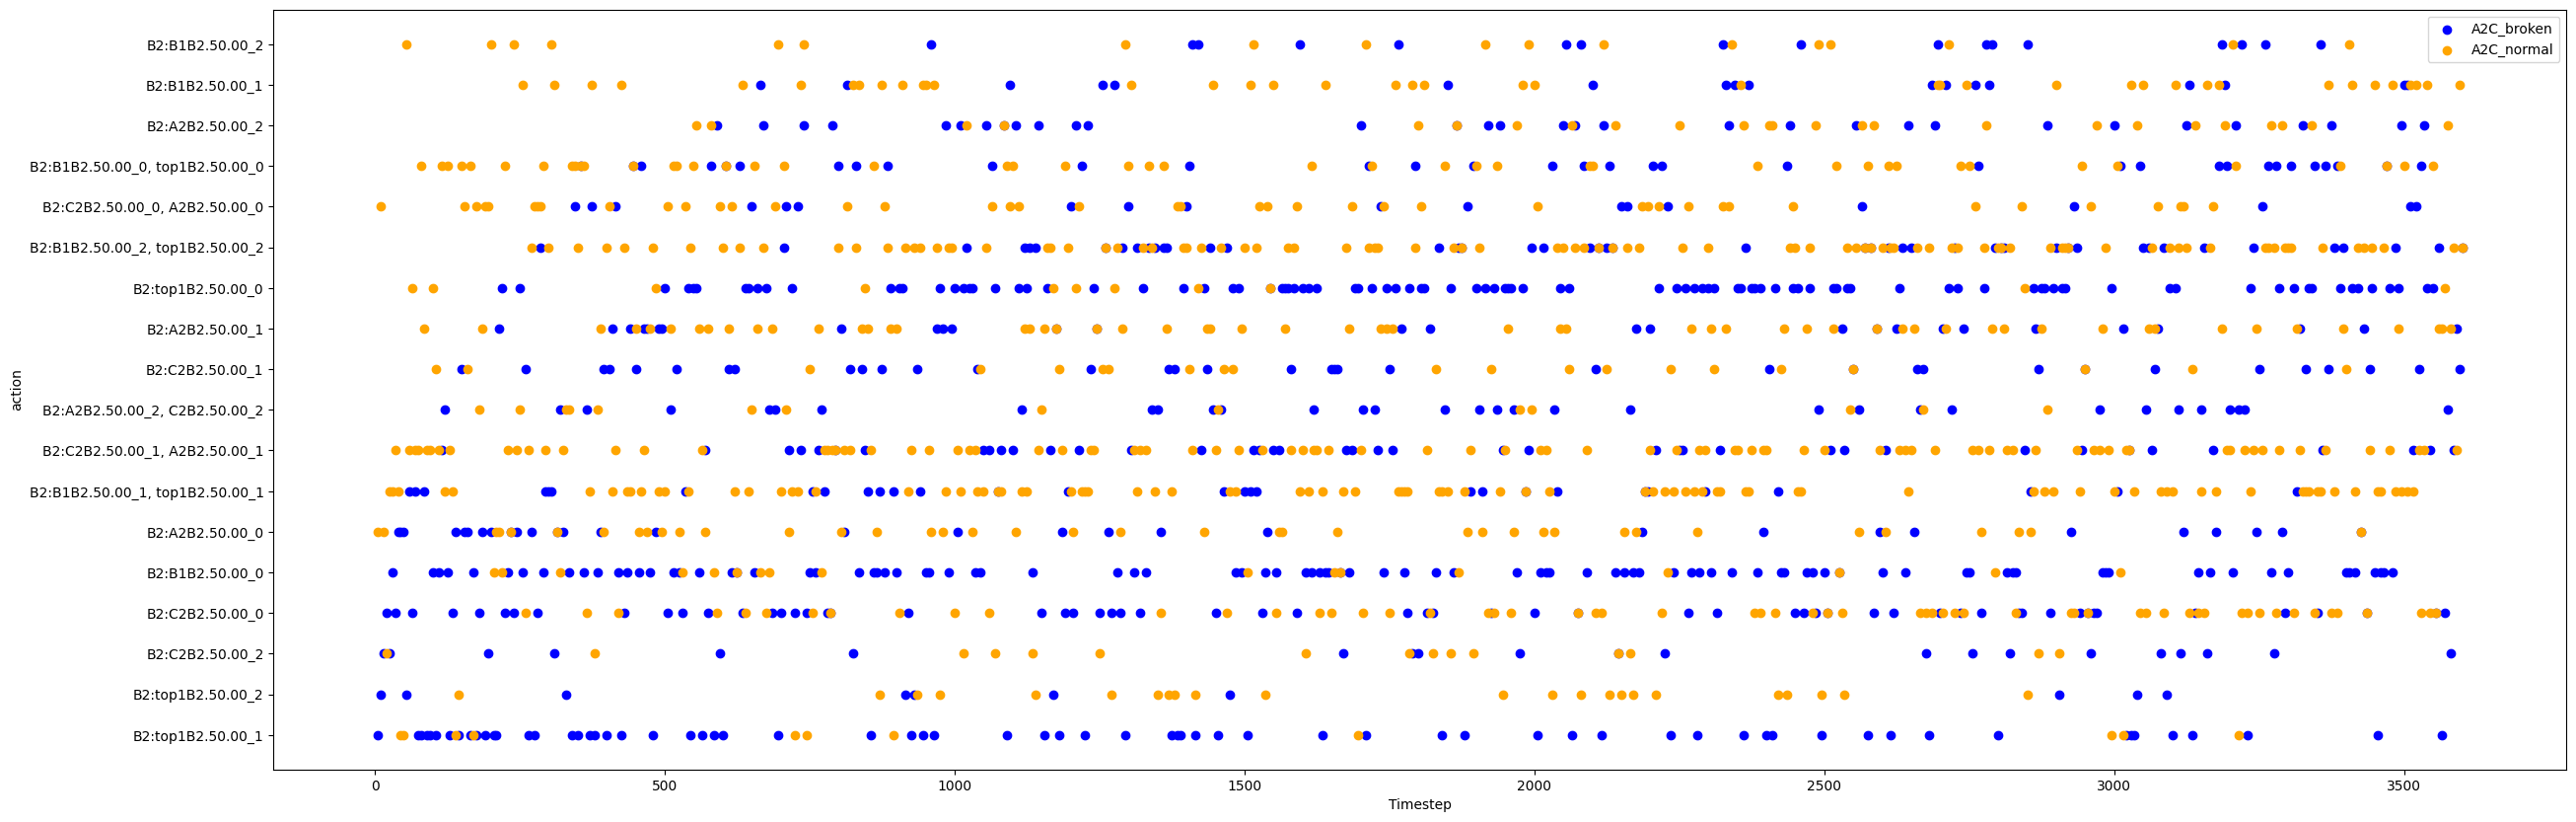

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 5


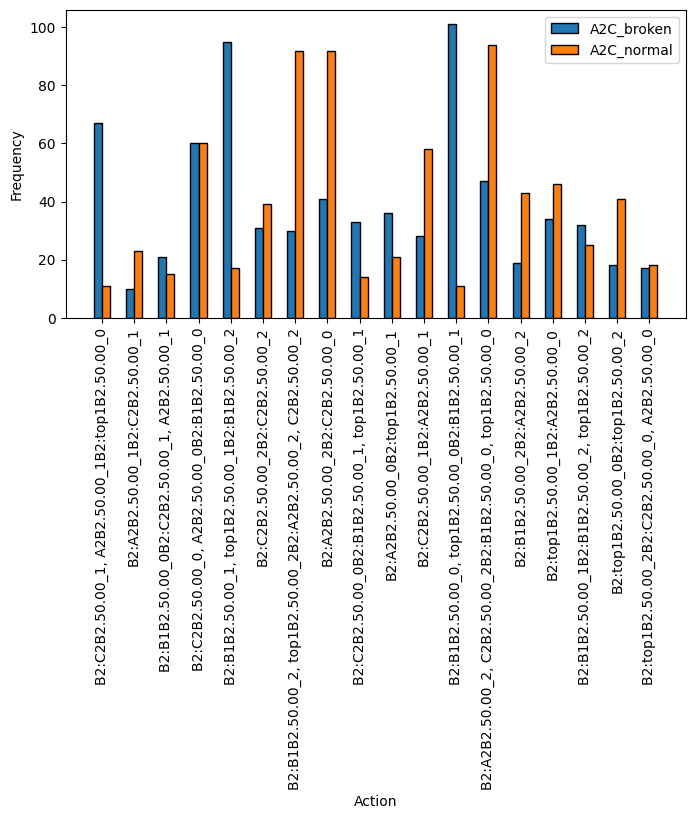

B1 actions for model low 241
B1 actions for model high 308
Results 3x3grid-3lanes2 translated_action_tf_6
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 6


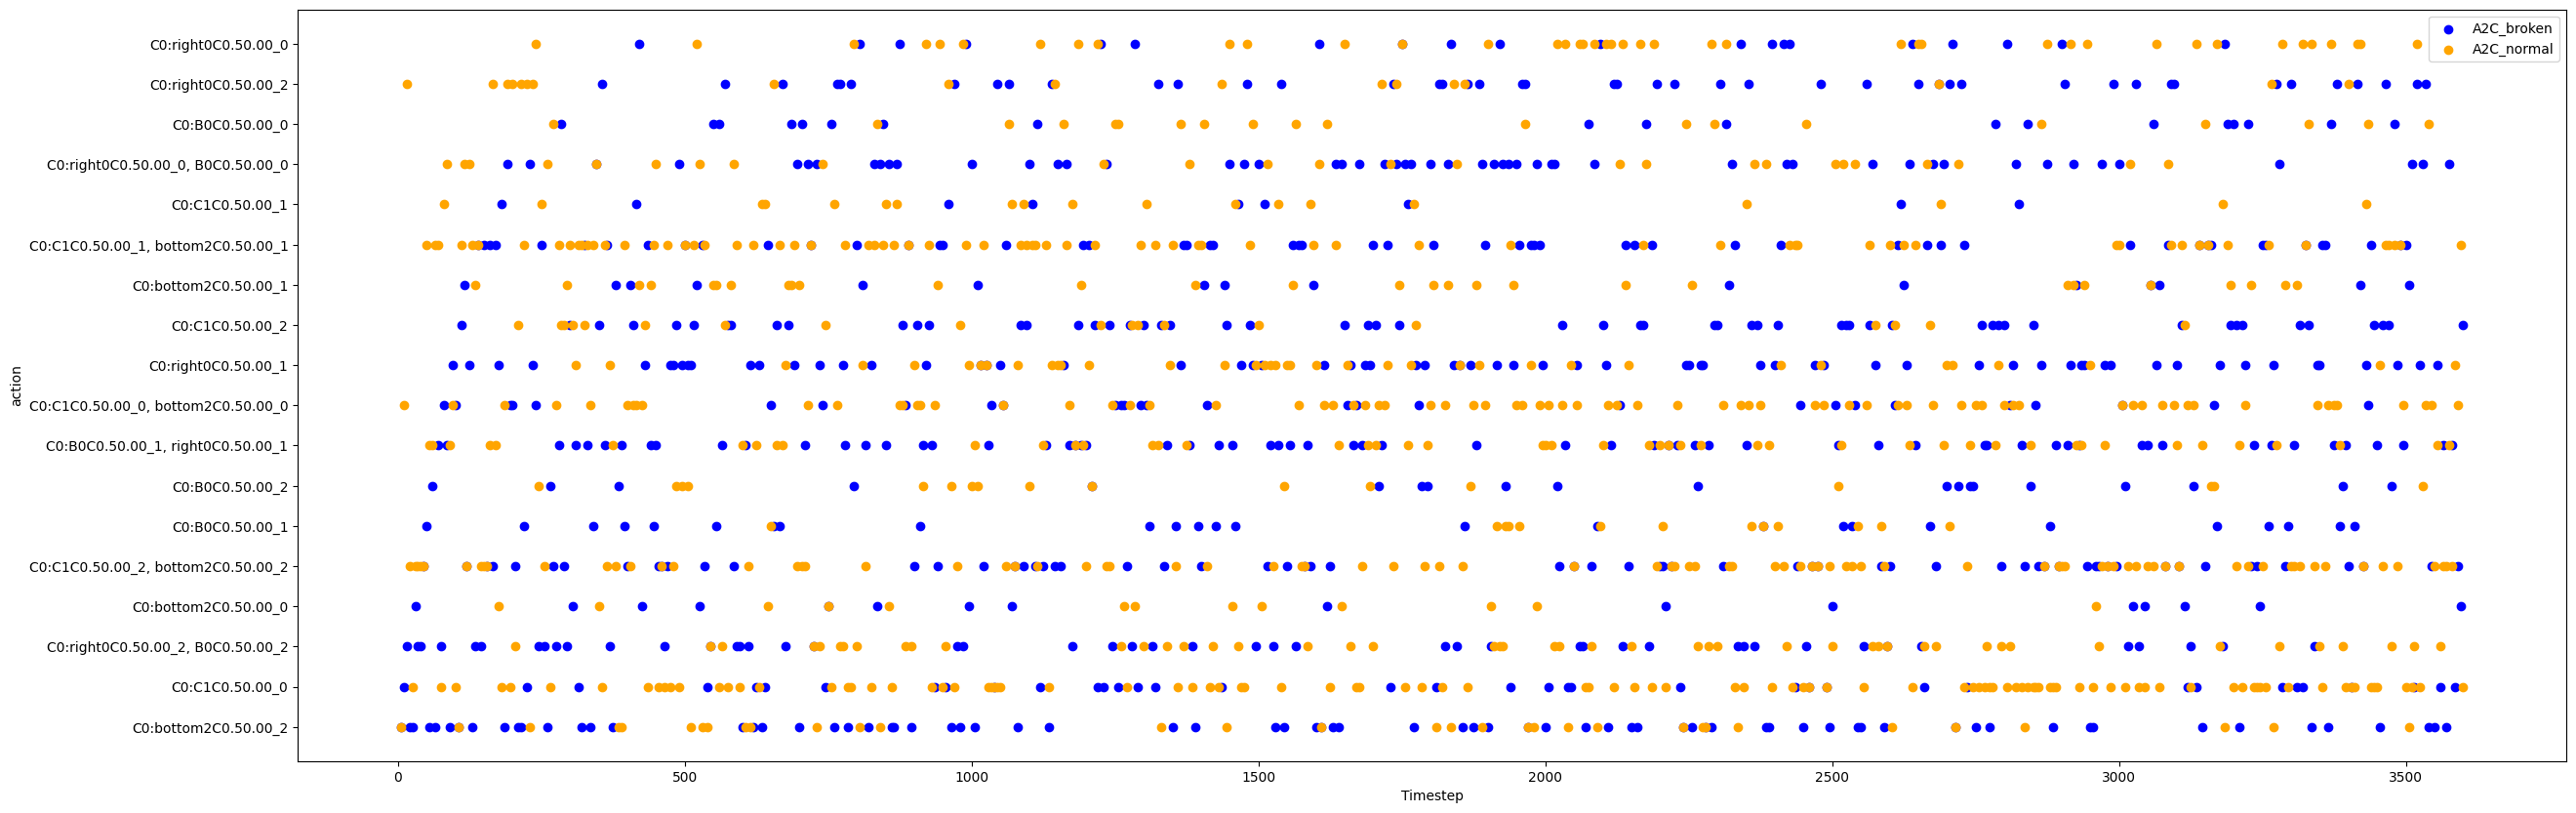

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 6


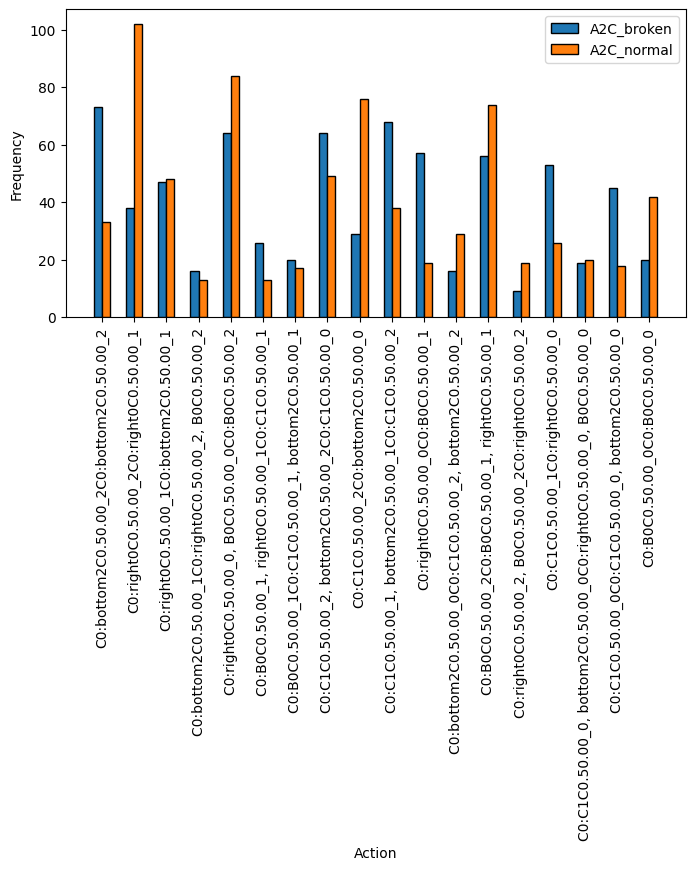

B1 actions for model low 0
B1 actions for model high 0
Results 3x3grid-3lanes2 translated_action_tf_7
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 7


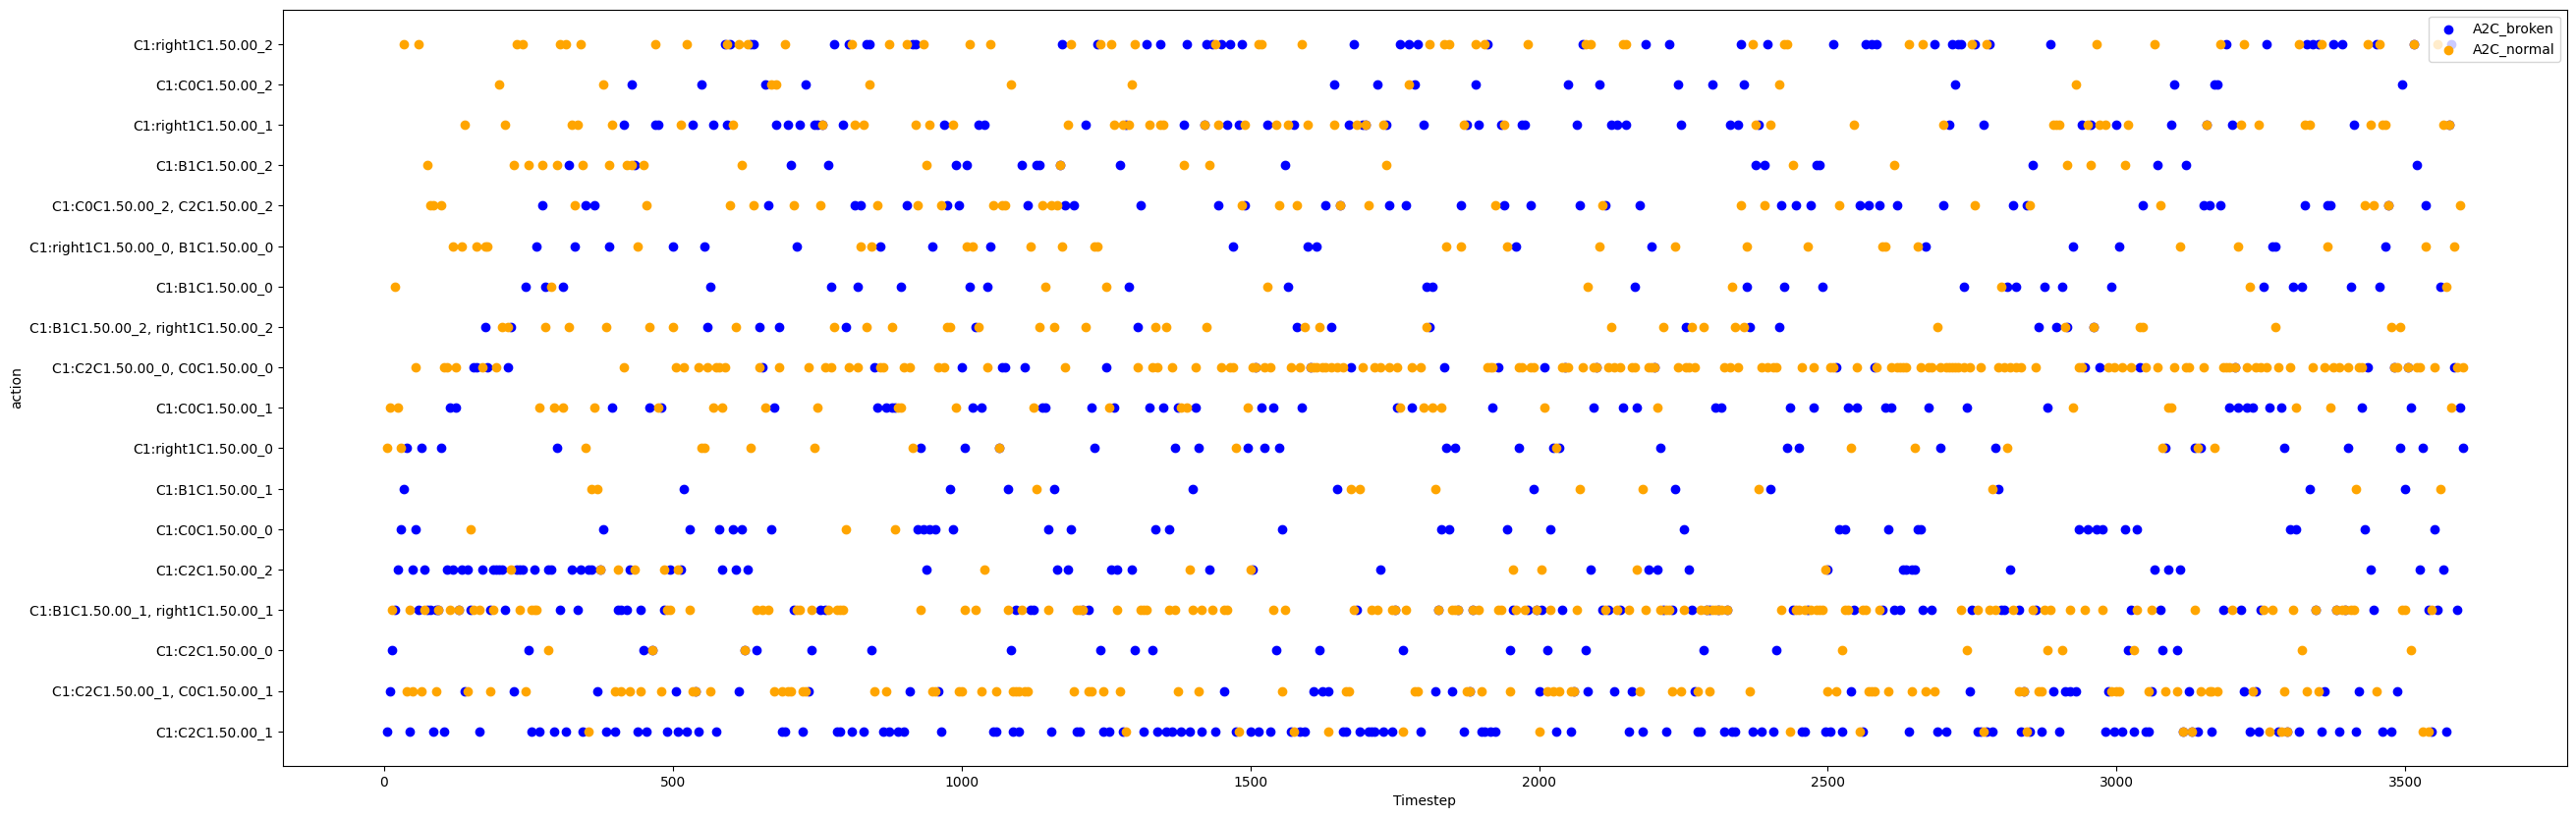

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 7


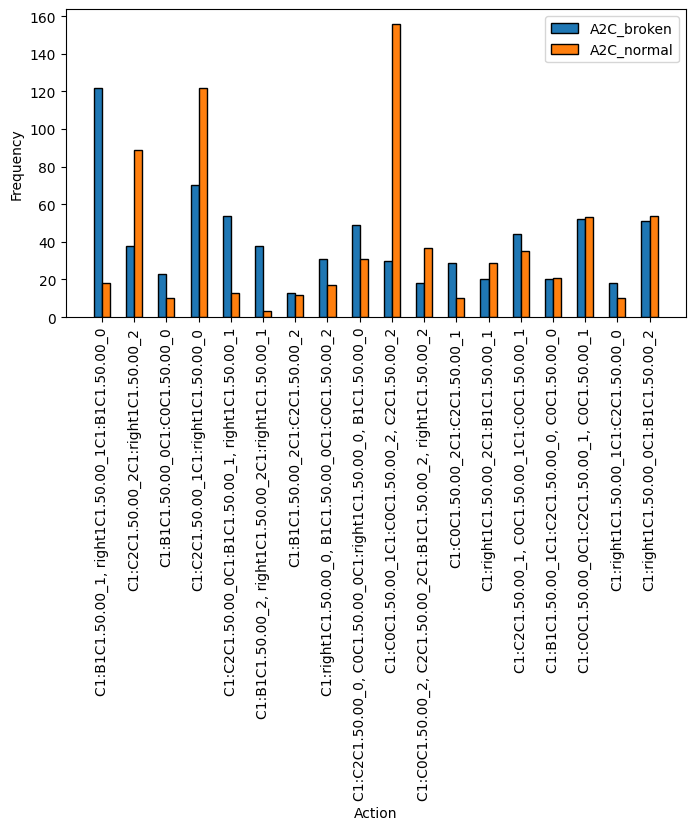

B1 actions for model low 170
B1 actions for model high 231
Results 3x3grid-3lanes2 translated_action_tf_8
Actions Over Time for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 8


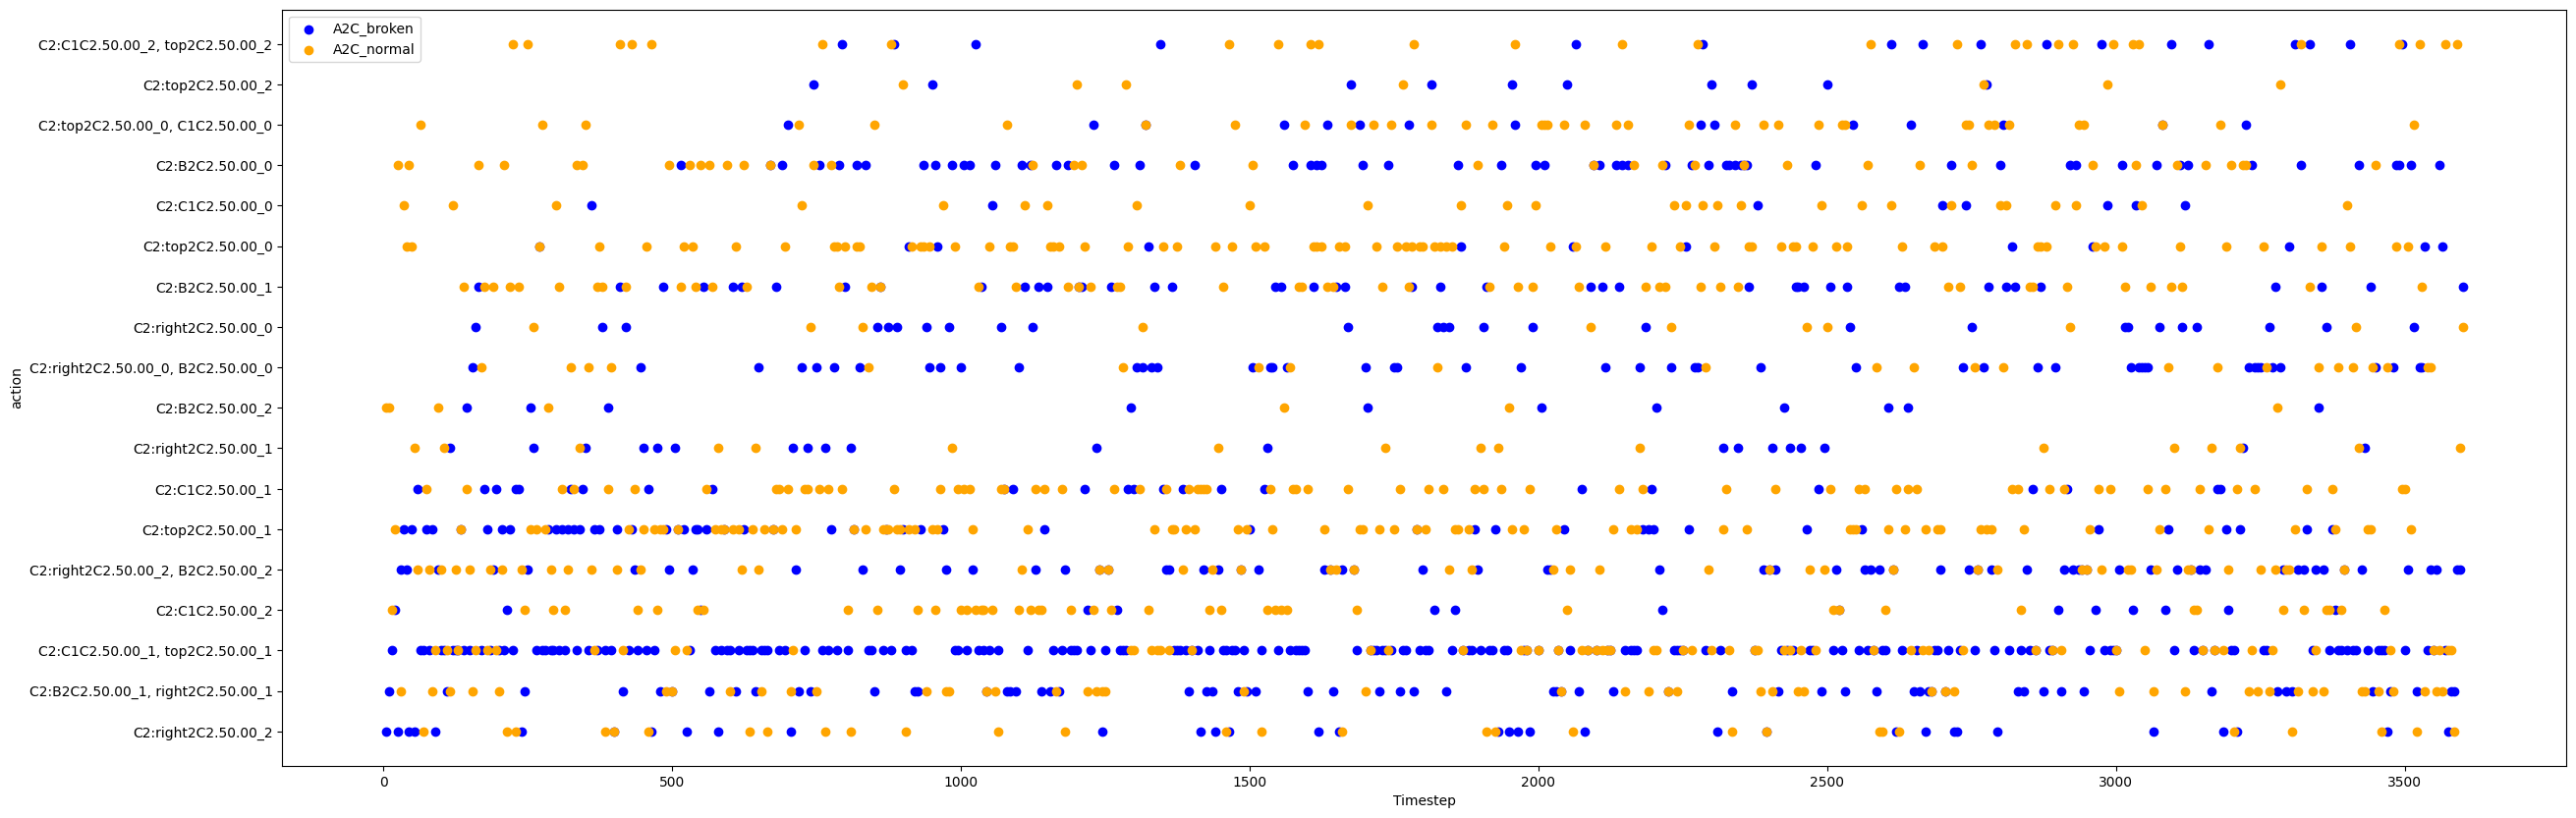

Action Distribution for a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1 traffic signal 8


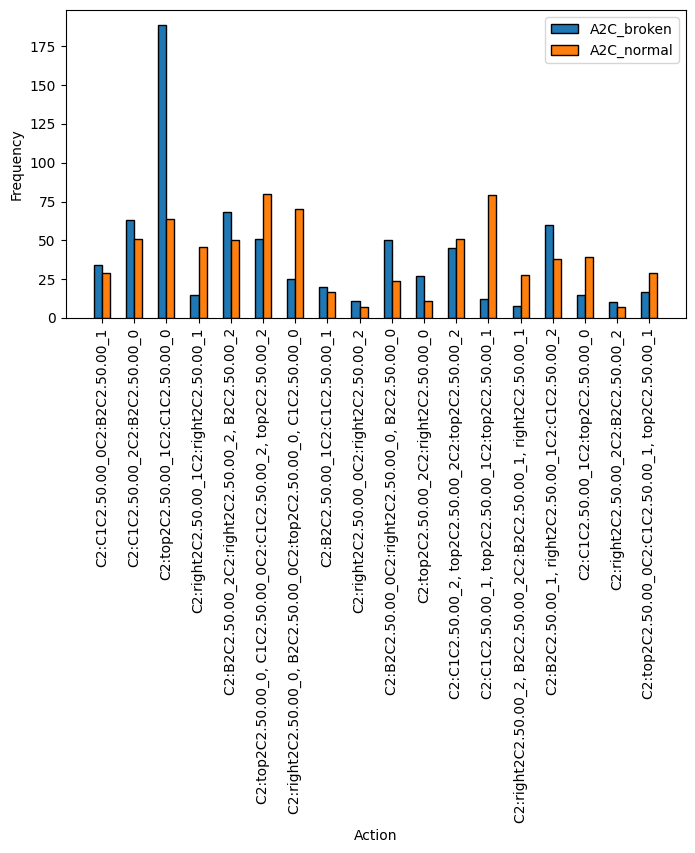

B1 actions for model low 0
B1 actions for model high 0


In [61]:
traffic = '3x3grid-3lanes2'
# df_single_episode_low, _ = load_data(f"{MODEL_LOW}_broken", traffic)
# df_single_episode_high, _ = load_data(f"{MODEL_HIGH}_broken", traffic)
n_splits = len(df_single_episode.translated_action.to_list()[0].split("; "))
for i in range(n_splits):
    column = f"translated_action_tf_{i}"
    print("Results", traffic, column)
    
    grouped = pd.DataFrame({f'{column}_model_low': df_single_episode_low[column],
                            f'{column}_model_high': df_single_episode_high[column]}) 
    
    plt.figure(figsize=(30, 10))
    plt.scatter(grouped.index, grouped[f"{column}_model_low"], color="blue", label="A2C_broken")
    plt.scatter(grouped.index, grouped[f"{column}_model_high"], color="orange", label="A2C_normal")

    plt.xlabel("Timestep")
    plt.ylabel("action")
    print(f"Actions Over Time for {MODEL_LOW} traffic signal {i}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,4))
    categories = set(grouped[f'{column}_model_low'].unique() + grouped[f'{column}_model_high'].unique())

    plt.hist(grouped[[f'{column}_model_low', f'{column}_model_high']], label=["A2C_broken", "A2C_normal"],
             rwidth=0.5,
            bins=np.arange(len(categories)+1)-0.5, edgecolor='black')
    
    # Set custom tick positions and labels
    plt.xticks(range(len(categories)), categories, rotation=90)

    plt.xlabel("Action")
    plt.ylabel("Frequency")
    print(f"Action Distribution for {MODEL_LOW} traffic signal {i}")
#     plt.xticks(rotation=90)
    plt.legend()
    plt.show()
    print("B1 actions for model low", grouped[f'{column}_model_low'].apply(lambda g: "b1" in g.lower()).sum())
    print("B1 actions for model high", grouped[f'{column}_model_high'].apply(lambda g: "b1" in g.lower()).sum())

In [62]:
MODEL_LOW

'a2c_broken_3x3grid-3lanes2_250000_stepsintelli_light_prcol_reward_delay_3_waiting_time_2_light_switches_1_out_lanes_availability_1'

In [ ]:
df_single_episode.action.to_list()[0]

In [ ]:
df_single_episode

In [ ]:
traffic = "custom-2way-single-intersection-high"
df_single_episode, _ = load_data(MODEL_LOW, traffic)
print("Results", MODEL_LOW, traffic)

plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x=column, hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

In [ ]:
traffic = "custom-2way-single-intersection-high"
df_single_episode, _ = load_data(MODEL_HIGH, traffic)
print("Results", MODEL_HIGH, traffic)
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

In [ ]:
def get_obs(df, index, traffic):
    total_observation = []
    unnested_obs = {}
    
    with open(f"./meta/{traffic}.json") as f:
        meta_data = json.load(f)
    
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():        
        # current_time = observation_dict["current_time"]
        phase_ids = observation_dict["current_phase_ids"]
        # phase_ids = observation_dict["hist_phase_ids"]
        # min_green = observation_dict["min_green"]
        # density = observation_dict["density"]
        queue = observation_dict["queue"]
        # queue_der = observation_dict["queue_der"]
        # average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.max(waiting_time))
            else:
                waiting_times.append(0)
        # observation = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        observation = np.array(phase_ids + queue + waiting_times, dtype=np.float32)
        
        # TODO: check if I can update the phase ids?
        # TODO: double check queue_der
        tf_meta_data = meta_data[tf_id]        
        
        total_observation.extend(observation)
        for key, value in observation_dict.items():           
            if isinstance(value, list):
                for index, item in enumerate(value):
                    suffix = index
                    if key in ["queue"]:
                        suffix = tf_meta_data["lanes"]["cleaned_incoming"][str(index)]
                    unnested_obs[f"{tf_id}_{key}_{suffix}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)    


    return total_observation, current_option, unnested_obs

def __get_action_distribution(obs, policy_model):
    """Get the action distribution for the given state and option.

    Args:
        state: State to calculate the action distribution for.
        model: Model to calculate the action distribution with.
        option: Option to calculate the action distribution for.

    Returns:
        array: Numpy array with the action distribution.
    """
    state = {}
    for key, observation_dict in obs.items():
        phase_ids = observation_dict["hist_phase_ids"]
        queue = observation_dict["queue"]
        queue_der = observation_dict["queue_der"]
        average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.mean(waiting_time))
            else:
                waiting_times.append(0)
        combined_obs = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        state[key] = torch.tensor([combined_obs], dtype=torch.float32, device="cuda")
    return policy_model.get_distribution(state).distribution[0].probs.cpu().detach().numpy()[0]


def hellinger_distance(state, model_1, model_2) -> float:
    """Calculate the hellinger distance between the intra-option policies of the model
    for the given state.
    This as defined in the paper "Disentangling Options with Hellinger Distance Regularizer"

    Args:
        states: The states for which to calculate the hellinger distance.
        model: The option critic model to calculate the distance for.

    Returns:
        float: Helling distance loss
    """
    p_dist = __get_action_distribution(state, model_1.policy)
    q_dist = __get_action_distribution(state, model_2.policy)
    summation = np.sum((np.sqrt(p_dist) - np.sqrt(q_dist)) ** 2)
    hd = math.sqrt(summation) / math.sqrt(2)
    return hd


In [ ]:
model_high = stable_baselines3.A2C.load(
    f"./models/{MODEL_HIGH}.zip"
)

model_low = stable_baselines3.A2C.load(
    f"./models/{MODEL_LOW}.zip"
)

In [ ]:
obs

In [ ]:
traffic = "custom-2way-single-intersection-high"
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

results = []
distances = []
for index in range(df_single_episode_high.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode_high, index, traffic)
    results.append({
        "step": index*5,
        "action_high": model_high.predict({"t": obs})[0][0],
        "action_low": model_low.predict({"t": obs})[0][0]
    })
    hd_distance = hellinger_distance(json.loads(df_single_episode_high.obs.to_list()[index]), model_low, model_high)
    distances.append(hd_distance)
    
df_action_comparision = pd.DataFrame(results)
# df_action_comparision = df_action_comparision.set_index('step')
print(df_action_comparision.shape)
print("equal", df_action_comparision[df_action_comparision.action_high == df_action_comparision.action_low].shape[0])
print(np.mean(distances), np.std(distances))
print(np.max(distances), np.min(distances))

In [ ]:
traffic = "custom-2way-single-intersection-low"
df_single_episode_high, _ = load_data(MODEL_HIGH, traffic)

results = []
distances = []
for index in range(df_single_episode_high.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode_high, index, traffic)
    results.append({
        "step": index*5,
        "action_high": model_high.predict({"t": obs})[0][0],
        "action_low": model_low.predict({"t": obs})[0][0]
    })
    hd_distance = hellinger_distance(json.loads(df_single_episode_high.obs.to_list()[index]), model_low, model_high)
    distances.append(hd_distance)
    
df_action_comparision = pd.DataFrame(results)
# df_action_comparision = df_action_comparision.set_index('step')
print(df_action_comparision.shape)
print("equal", df_action_comparision[df_action_comparision.action_high == df_action_comparision.action_low].shape[0])
print(np.mean(distances), np.std(distances))
print(np.max(distances), np.min(distances))

In [ ]:
plt.figure(figsize=(30, 20))

# Scatter plot for Column2
plt.scatter(df_action_comparision['step'], df_action_comparision['action_high'], color='blue', label='action_high', alpha=0.7)

# Scatter plot for Column3
plt.scatter(df_action_comparision['step'], df_action_comparision['action_low'], color='red', label='action_low', alpha=0.7)

# Labels and title
plt.xlabel('step')
plt.ylabel('actions')

# Show legend
plt.legend()

# Show plot
plt.show()

In [ ]:

def find_repeating_patterns(df, column, window_size):
    """
    Find repeating sequences of length `window_size` in a given column of a DataFrame.
    """
    patterns = defaultdict(list)
    series = df[column].tolist()

    # Store occurrences of each pattern
    for i in range(len(series) - window_size + 1):
        pattern = tuple(series[i : i + window_size])  # Convert slice to tuple (hashable)
        patterns[pattern].append(i)  # Store start index of pattern

    # Filter only repeating patterns
    repeating_patterns = {k: len(v) for k, v in patterns.items() if len(v) > 1}
    return repeating_patterns

repeating_patterns_high = find_repeating_patterns(df_action_comparision, 'action_high', window_size=4)
repeating_patterns_low = find_repeating_patterns(df_action_comparision, 'action_low', window_size=4)

In [ ]:
df_repeating_high = pd.DataFrame([{"cycle": key, "count": value}
                                 for key, value in repeating_patterns_high.items()])
df_repeating_low = pd.DataFrame([{"cycle": key, "count": value}
                                 for key, value in repeating_patterns_low.items()])
df_repeating_comparision = df_repeating_high.merge(df_repeating_low, on="cycle", how="outer")

In [ ]:
df_repeating_comparision

In [ ]:
results = []
for _, row in df_single_episode.iterrows():
    obs = [float(s.strip()) for s in row.obs.split(',')]
    state = agent.get_state(to_tensor(obs))
    option_distributions_dict = {}
    for option in range(0, df_single_episode.option.max() + 1):
        dist = get_action_dist(agent, state, option)[0]
        for i, value in enumerate(dist):
            if i not in option_distributions_dict:
                option_distributions_dict[i] = {'action': i}
            option_distributions_dict[i][f'prob_option_{option}'] = value        
    results.append(option_distributions_dict)
avg_dist = {key: {'action': key, 'prob_option_0': 0, 'prob_option_1': 0} for key in results[0].keys()}
for item in results:
    for key, value in item.items():
        for option in range(n_options):
            option_prob = f'prob_option_{option}'
            avg_dist[key][option_prob] += value[option_prob]
for _, value in avg_dist.items():
    for option in range(n_options):
        option_prob = f'prob_option_{option}'
        value[option_prob] = value[option_prob] / len(results)
df_avg_action_distributions = pd.DataFrame(list(avg_dist.values()))
px.bar(
    data_frame = df_avg_action_distributions,
    x = "action",
    y = [f'prob_option_{option}' for option in range(n_options)],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
)

In [ ]:
results = []
for _, row in df_single_episode.iterrows():
    obs = [float(s.strip()) for s in row.obs.split(',')]
    state = agent.get_state(to_tensor(obs))
    option_distributions_dict = {}
    for option in range(0, df_single_episode.option.max() + 1):
        dist = get_action_dist(agent, state, option)[0]
        for i, value in enumerate(dist):
            if i not in option_distributions_dict:
                option_distributions_dict[i] = {'action': i}
            option_distributions_dict[i][f'prob_option_{option}'] = value        
    results.append(option_distributions_dict)
avg_dist = {key: {'action': key, 'prob_option_0': 0, 'prob_option_1': 0} for key in results[0].keys()}
n_options = 2
for item in results:
    for key, value in item.items():
        for option in range(n_options):
            option_prob = f'prob_option_{option}'
            avg_dist[key][option_prob] += value[option_prob]
for _, value in avg_dist.items():
    for option in range(n_options):
        option_prob = f'prob_option_{option}'
        value[option_prob] = value[option_prob] / len(results)
df_avg_action_distributions = pd.DataFrame(list(avg_dist.values()))
px.bar(
    data_frame = df_avg_action_distributions,
    x = "action",
    y = [f'prob_option_{option}' for option in range(n_options)],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
)

In [ ]:
df_action_encoded = pd.get_dummies(df_single_episode[['action', 'option']], columns=['action', ])

In [ ]:
df_action_encoded.groupby('option').sum()

In [ ]:
lanes = ['n_t_0', 'n_t_1', 'e_t_0', 'e_t_1', 's_t_0', 's_t_1', 'w_t_0', 'w_t_1']
          0          1         2       3         4         5     6        7

In [ ]:
# backup
option_distributions = []
for option in range(0, df_single_episode.option.max() + 1):
    dist = get_action_dist(agent, state, option)[0]
    for i, value in enumerate(dist):
        dist_dict = {
            'option': option
        }
        dist_dict[f'action'] = i
        dist_dict[f'prob'] = value
        option_distributions.append(dist_dict)
df_option_distributions = pd.DataFrame(option_distributions)
fig, ax = plt.subplots()

for key, grp in df_option_distributions.groupby(['option']):
    key = key[0]
    ax = grp.plot(ax=ax, kind='line', x='action', y='prob', label=key)

plt.legend(loc='best')
plt.show()

In [ ]:
pd.read_csv("./")